# Reinforcement Learning for Limit Texas Hold'em

## Table of Contents

* [0. Prerequisites](#chap0)
* [1. Abstract](#chap1)
* [2. Introduction](#chap2)
    * [2.1 Texas Hold'em](#2.1)
    * [2.2 RL Card Environment](#2.2)
    * [2.3 State Representation of Texas Hold'em](#2.3)
    * [2.4 Demo Setup of RL Card](#2.4)
* [3. Methodologies](#chap3)
    * [3.1 Counterfactual Regret Minimization (CFR)](#3.1)
    * [3.2 Double-Q-Learning](#3.2)
    * [3.3 Double-DQN-Agent](#3.3)
    * [3.4 Deep Fitted Q-Iteration](#3.4)
    * [3.5 Policy Based methods](#3.5)
    * [3.6 Neural Fictitious Self-Play (NFSP)](#3.6)
    * [3.7 Demonstration of Manual Play against Methods trained on a Random Agent](#3.7)
* [4. Applying Methods to Rule-Based Agents](#chap4)
    * [4.1 Double-DQN-Agent vs. Rule-Based](#4.1)
    * [4.2 Deep Fitted Q-Iteration vs. Rule-Based](#4.2)
    * [4.3 Deep Fitted Q-Iteration vs. Double Deep Q-Network](#4.2)
    * [4.4 Demonstration of Manual Play Against Implemented Agents](#4.3)
* [5. Conclusion](#chap5)



## 0. Prerequisites <a class="anchor" id="chap0"></a>

In [ ]:
#!pip3 install rlcard
#!pip3 install rlcard[torch]
#!pip3 install argparse
#!pip3 install pprint

In [5]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import rlcard
import joblib
import itertools
import matplotlib.pyplot as plt

from rlcard import models

from rlcard.agents import RandomAgent, DQNAgent, NFSPAgent, CFRAgent
from rlcard.agents import LimitholdemHumanAgent as HumanAgent

from rlcard.utils import Logger, plot_curve, tournament, reorganize, set_seed
from rlcard.utils.utils import remove_illegal, print_card

from collections import namedtuple, defaultdict, deque
from copy import deepcopy
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## 1. Abstract <a class="anchor" id="chap1"></a>

### Abstract

This project investigates and implements self-playing models for Texas Hold'em using the RLCard library. We develop custom reinforcement learning (RL) agents, focusing on value approximation and policy-based learning models, trained against random and rule-based opponents. Our research analyzes reward progression across different models and setups, comparing established methods like Double Deep Q-Network (Double DQN) and novel approaches such as Deep Fitted Q-Iteration and Advantage Actor-Critic (A2C) with Fitted Q Iteration.

Findings indicate that while Double DQN performs well, novel methods, particularly Deep Fitted Q-Iteration, show promise by achieving high rewards against random agents and even outperforming the traditional method in a direct comparison. Methods like Counterfactual Regret Minimization (CFR) and Double Q-Learning face challenges due to poker's complexity. This study highlights the need for tailored RL approaches for strategic games and provides insights for developing more robust poker-playing agents, laying the foundation for further RL algorithm optimization.

## 2. Introduction <a class="anchor" id="chap2"></a>

Texas Hold'em is one of the most widely known variants of poker (henceforth referred to simply as poker). While poker is often misconceived as merely a gambling game, beneath the allure of casino lights lies a complex interplay of skill, psychology, and mathematics. In this section, we explore why poker transcends pure chance:

#### Skillful Decision-Making
Unlike games of pure luck, poker demands strategic choices. Players assess incomplete information, including their hand cards and community cards, to decide when to fold, call, or raise. Mastery in poker involves reading opponents, managing bankrolls, and adapting to dynamic scenarios.

#### Psychological Strategies
Bluffing, a cornerstone of poker, allows players to manipulate perceptions. The amount a player bets at various stages significantly impacts the game's outcome. Successfully detecting opponents’ actions and leveraging this information in psychological mind games is crucial to winning in poker.

#### Positional Advantage
Each game starts with a different order of turns to be played. Early positions require caution due to limited information, while later positions benefit from observing opponents before making decisions. Understanding positional play is critical for success in poker.

#### Mathematics and Probabilities
Poker is fundamentally a numbers game. Calculating odds and expected values guides decisions, and risk-reward analysis helps determine optimal plays. This mathematical approach is essential for strategic decision-making.

#### Adaptability and Game Theory
Skilled players adjust their strategies based on opponents’ tendencies. Concepts from game theory, such as the Nash equilibrium, where players balance optimal strategies, are integral to high-level poker play.

In summary, mastery in poker involves a synthesis of various skills underpinned by logical reasoning and strategic thinking. This project aims to implement reinforcement learning techniques to develop a self-playing model that integrates these commonly understood aspects of poker. By doing so, we seek to observe how an artificial agent can emulate and potentially master the strategic depth of the game.

## 2.1 Texas Hold'em <a class="anchor" id="2.1"></a>

For this project, we will be using Limit Texas Hold'em, a variant of Texas Hold'em where each player can only raise by a fixed amount, and the number of raises per round is limited to four.

### Game Mechanics of Limit Texas Hold'em

Here are the five general rounds of how a game of poker is played out:

#### Round 0: Setup

Players sit around a circular table. Each game, one player holds a 'button' (indicating the dealer position), and the button moves clockwise after each game. The player to the left of the button is the 'small blind,' and the player to the left of the small blind is the 'big blind.' The small blind and big blind make mandatory bets (SB and BB, where BB = 2 * SB) before the game begins. The amounts of SB and BB vary by game. Now, the four main rounds of a game begin, each involving card dealing/opening followed by a betting round.

#### Round 1: Pre-Flop

From a standard 52-card deck, the dealer deals two private cards (known as the hand) to each player. After all players receive their hands, starting from the player to the left of the big blind, players begin making bets in a clockwise order. Players can choose from three actions: fold (no longer participate in the game), call (match the highest bet of the round, or check if no bets have been made), or raise (increase the highest bet of the round). The round ends when every player has either called the highest bet or folded.

#### Round 2: Flop

After the pre-flop betting round, the dealer places three community cards face up in the center of the table (known as the flop). Players use their hand in combination with the flop to form the best possible five-card combination. Starting from the small blind, another round of betting occurs.

#### Round 3: Turn

The fourth community card (the turn card) is revealed. Players reassess their hands, and another round of betting occurs.

#### Round 4: River

The fifth and final community card (the river) is revealed. Players make their final assessments of their complete hands, and the last round of betting occurs. After the betting ends, the remaining players reveal their hole cards, and the best hand wins the pot.

### Poker Hand Rankings

Here is the ranking of each poker hand.

![alt text](poker_hand_table_new.jpg "poker hand ranking")


## 2.2 RL Card Environment <a class="anchor" id="2.2"></a>
### About the RLCard Library

RLCard, developed by DATA Lab at Rice University and Texas A&M University, is a toolkit designed to facilitate reinforcement learning applications in various card games. Featuring user-friendly interfaces, RLCard supports the implementation of a wide range of reinforcement learning algorithms and search techniques across multiple card game environments. The library provides pre-defined environments for popular card games, including Texas Hold'em, but also Blackjack, and UNO. RLCard includes a variety of pre-implemented agents which we will make use of, such as DQN, NFSP, and CFR, which serve as excellent baselines for benchmarking new approaches. Further, its compatibility with popular deep learning frameworks such as TensorFlow and PyTorch, enabling integration with existing machine learning pipelines.

Overall, RLCard is a powerful and comprehensive toolkit that significantly lowers the barrier to entry for conducting advanced research in reinforcement learning for card games.


## 2.3 State, Actions and Reward Representation <a class="anchor" id="2.3"></a>

This section details the implementation of poker into a reinforcement learning environment, following the setup provided by the RLCard library.

The state is recorded as a vector with a length of 72. The first 52 indices represent the hand of each player, with each index corresponding to a specific card in ascending order. The hand is observed as the union of the player's hand and the community board cards. The remaining 20 indices represent the betting history, as Limit Texas Hold'em allows a maximum of four raises per round. The index representation for each card is as follows:

| State Index | Representation          |
|-------------|-------------------------|
| 0~12        | Spade A ~ Spade K       |
| 13~25       | Heart A ~ Heart K       |
| 26~38       | Diamond A ~ Diamond K   |
| 39~51       | Club A ~ Club K         |
| 52~56       | Raise number in round 1 |
| 57~61       | Raise number in round 2 |
| 62~66       | Raise number in round 3 |
| 67~71       | Raise number in round 4 |

There are four possible actions, represented as follows:

| Action Index | Representation |
|--------------|----------------|
| 0            | Call           |
| 1            | Raise          |
| 2            | Fold           |
| 3            | Check          |

The standard unit used for calculating the reward is big blinds per game (BB/game). For instance, a reward of 3/-3 indicates that the player won or lost three times the amount of the big blind.


## 2.4 Demo Setup of RL Card <a class="anchor" id="2.4"></a>

In this subsection, we showcase the capabilities of RLCard by creating a limit-holdem environment and establishing an interface where users can play poker games against a random agent.

In [6]:
env = rlcard.make("limit-holdem")

print("Number of actions:", env.num_actions)
print("Number of players:", env.num_players)
print("Shape of state:", env.state_shape)
print("Shape of action:", env.action_shape)

Number of actions: 4
Number of players: 2
Shape of state: [[72], [72]]
Shape of action: [None, None]


As previously mentioned, the environment allows for four types of actions (fold, check, call, raise) and accommodates a maximum of two players. The state representation consists of 72 spaces: The first 52 represent hand and board checkers, while the last 20 capture action records.

In [7]:
def manual_play(opponent_agent, num_games):

    env = rlcard.make('limit-holdem')
    human_agent = HumanAgent(env.num_actions)
    agent_0 = opponent_agent
    env.set_agents([human_agent, agent_0,])

    for i in range(num_games):
        print(">> Start a new game")

        trajectories, payoffs = env.run(is_training=False)
        # If the human does not take the final action, we need to
        # print other players action
        if len(trajectories[0]) != 0:
            final_state = trajectories[0][-1]
            action_record = final_state['action_record']
            state = final_state['raw_obs']
            _action_list = []
            for i in range(1, len(action_record)+1):
                """
                if action_record[-i][0] == state['current_player']:
                    break
                """
                _action_list.insert(0, action_record[-i])
            for pair in _action_list:
                print('>> Player', pair[0], 'chooses', pair[1])

        # Let's take a look at what the agent card is
        print('=============     Random Agent    ============')
        print_card(env.get_perfect_information()['hand_cards'][1])

        print('===============     Result     ===============')
        if payoffs[0] > 0:
            print('You win {} chips!'.format(payoffs[0]))
        elif payoffs[0] == 0:
            print('It is a tie.')
        else:
            print('You lose {} chips!'.format(-payoffs[0]))
        print('')

        input("Press any key to continue...")

In [8]:
manual_play(opponent_agent = RandomAgent(num_actions=env.num_actions), num_games = 5)

>> Start a new game

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│10       │   │9        │
│         │   │         │
│         │   │         │
│    ♣    │   │    ♣    │
│         │   │         │
│         │   │         │
│       01│   │        9│
└─────────┘   └─────────┘
===============     Chips      ===============
Yours:   +
+++
=========== Actions You Can Choose ===========
0: call, 1: raise, 2: fold

>> You choose action (integer): 1
>> Player 0 chooses raise
>> Player 1 chooses raise

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│10       │   │9        │
│         │   │         │
│         │   │         │
│    ♣    │   │    ♣    │
│         │   │         │
│         │   │         │
│       01│   │        9│
└─────────┘   └─────────┘
===============     Chips      ===============
Yours:   ++++
++++++++++
=========

Five games of poker were manually played using the RLCard environment against a random agent. The results reveal a strategy of consistently raising or calling, aiming to maximize rewards. This approach exploits the fact that the random agent is highly likely to eventually choose the option to fold.

## 3. Methodology: Building a Limit Texas Hold'em Poker Agent <a class="anchor" id="chap3"></a>

To create a Limit Texas Hold'em poker agent, we have multiple options from classical Reinforcement Learning (RL) methods such as Monte Carlo (MC) methods, Temporal Difference (TD) learning (like Q-learning), and more advanced techniques like Deep Reinforcement Learning. To implement a practical agent, we use methods provided in RLcard and extend them with our own code.

Each approach follows a number of steps, where we set up appropriate environments and instances for the agent to interact with, and then implement a reinforcement learning agent to play the game. After training and fine-tuning we then analyse and compare the results. For any given method the process is simplified as follows:

##### Step 1: Environment Setup
We initialize the Texas Hold'em environment from RLCard. This environment will automatically handle the state and action representations:

  ```python
  import rlcard
  from rlcard.agents import RandomAgent

  env = rlcard.make('limit-holdem', config={'single_agent_mode':True})

  ```

##### Step 2: Defining and Implementing the RL Method

Select one of the RL methods discussed below and implement an agent using the RLCard library and our own code. Some methods may require fine-tuning and specific adjustments to function optimally.

##### Step 3: Training the Agent

- **Simulation**: Conduct simulations where the agent competes against a random agent to gather experience.
- **Rewards**: Use game outcomes as direct learning signals for the agent.
- **Evaluation**: Regularly assess the agent's performance with a separate evaluation environment to track its progress and performance.

##### Step 4: Integration and Tuning

**Parameter Tuning**: Adjust learning rates, exploration rates, discount factors, and other key parameters based on the agent's performance. We test different parameter configurations for all methods and perform extensive grid searches for the most complex models to identify the optimal parameters.

##### Step 5: Analyzing Performance and Comparing Methods

Evaluate the agent's performance comprehensively and compare it to other methods to determine its effectiveness.

##### Example Code Snippet

Below is a simplified example demonstrating the setup with a random agent and a DQN agent provided by RLCard:

```python
import rlcard
from rlcard.agents import RandomAgent, DQNAgent
from rlcard.utils import Logger, plot_curve, tournament, reorganize

# Make the environment with Limit Texas Hold'em
env = rlcard.make('limit-holdem')
eval_env = rlcard.make('limit-holdem')
print("Number of actions:", env.num_actions)
print("Number of players:", env.num_players)
print("Shape of state:", env.state_shape)
print("Shape of action:", env.action_shape)

# Initialize a DQN agent
agent = agent_name(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    ...,
    ...
)

# Set the agents in the environment
env.set_agents([agent, RandomAgent(num_actions=env.num_actions)])
eval_env.set_agents([agent, RandomAgent(num_actions=env.num_actions)])

# Initialize the Logger
with Logger("experiments/agent_name") as logger:
    for episode in range(5000):
        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance every 100 episodes
        if episode % 100 == 0:
            print(f'Episode {episode}')
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    1000  # Reduce for quicker evaluations
                )[0]
            )

    # Get the paths for the learning curve
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, fig_path, 'AgentName')
```

This code initializes the Texas Hold'em environment and uses a random agent to play the game, which can be replaced by any of the agents we discuss in the following. In the pursuit of creating an effective poker agent, particularly for a game as strategically complex as Limit Texas Hold'em, several reinforcement learning methodologies stand out for their relevance and efficacy. Each methodology offers unique advantages and operates under different assumptions about the environment and the agent's capabilities.


## 3.1 Counterfactual Regret Minimization (CFR) <a class="anchor" id="3.1"></a>

Counterfactual Regret Minimization (CFR) algorithm presents a potent tool for tackling the complexities of strategic decision-making in games such as Texas Hold'em. In the realm of Limit Texas Hold'em, where actions reverberate across multiple betting rounds and decisions are intertwined with uncertainties regarding opponents' actions, CFR stands as a methodological cornerstone due to several factors:

### 3.1.1 Key Characteristics of CFR

- **Adaptability to Imperfect Information:** Unlike deterministic methods, CFR can navigate games with imperfect information, where players lack full knowledge of each other's cards. This adaptability is crucial in poker, where players must make decisions based on incomplete information about their opponents' holdings.
- **Efficient Handling of Large State Spaces:** CFR efficiently handles the vast state spaces inherent in poker by focusing on learning from experience rather than exhaustive enumeration of all possible states. This is particularly pertinent in Texas Hold'em, where the number of potential game states grows exponentially with the number of players and betting rounds.
- **Ability to Learn Online:** CFR's iterative nature enables online learning, allowing agents to continually refine their strategies as they encounter new situations and opponents. This real-time adaptation is invaluable in dynamic environments like poker, where opponents may adjust their strategies in response to the agent's actions.

Given these considerations, CFR emerges as a prime candidate for implementing reinforcement learning strategies in Texas Hold'em, offering a principled approach to learning effective strategies in the face of uncertainty.

### 3.1.2 How CFR Works
Counterfactual Regret Minimization operates by iteratively improving strategies through self-play, iteratively correcting regrets associated with past actions. Here's a breakdown of the algorithm's steps as applied to Texas Hold'em:

**Regret Calculation and Strategy Improvement**

- **Information Set Formation:** Define information sets for each player, encapsulating the possible private information each player may hold at any point in the game.
- **Regret Calculation:** For each information set, calculate the regret associated with each action taken in the past. Regret is the difference between the utility of the action taken and the utility that would have been achieved by taking the optimal action at that information set.
- **Strategy Improvement:** Adjust the strategy for each information set based on the accumulated regrets. Actions with higher cumulative positive regrets are favored, while those with negative regrets are deemphasized.

**Exploration and Exploitation**

- **Stochastic Strategy:** CFR introduces stochasticity into the agent's strategy, allowing for exploration of different actions and adaptation to opponents' strategies over time.
- **Regret Matching:** The strategy update step employs regret matching, where the probability of selecting an action is proportional to its cumulative positive regret. This encourages exploration of actions with potentially high payoffs while gradually exploiting more successful actions.

### 3.1.3 Application to Limit Texas Hold'em Poker
- **Nash Equilibrium Approximation:** CFR converges to a Nash equilibrium strategy, providing a robust benchmark for optimal play against any opponent strategy.
- **Counterfactual Thinking:**  By simulating counterfactual scenarios and updating strategies based on regret, CFR encourages agents to consider alternative actions and anticipate opponents' responses, leading to more nuanced and adaptive gameplay.

**Implementation Considerations**
- **Memory Efficiency:** CFR's memory requirements can be significant, especially when dealing with large state spaces. Techniques such as abstraction and pruning are often employed to mitigate memory overhead.
- **Computational Complexity:** The computational demands of CFR can be substantial, particularly during the initial stages of learning. Parallelization and optimization techniques are commonly used to enhance efficiency.

### 3.1.4 Implementing CFR to Poker

To implement the CFR agent, the code structure needs to be changed slightly compared to the example we've seen above:

In [12]:
env = rlcard.make('limit-holdem',config={'allow_step_back': True})
eval_env = rlcard.make('limit-holdem')

CFRagent = CFRAgent(env,"experiments/limit_holdem_cfr_result/cfr_model")

eval_env.set_agents([
    CFRagent,
    RandomAgent(num_actions=env.num_actions),
])

In [14]:
with Logger("experiments/limit_holdem_cfr_result") as logger:
    for episode in range(100):
        CFRagent.train()
        print('\rIteration {}'.format(episode), end='')
        # Evaluate the performance. Play with Random agent.
        if episode % 5 == 0:
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    1000,
                )[0]
            )

    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path


Iteration 0
----------------------------------------
  episode      |  93131
  reward       |  -0.067
----------------------------------------
Iteration 5
----------------------------------------
  episode      |  322731
  reward       |  -0.033
----------------------------------------
Iteration 10
----------------------------------------
  episode      |  552331
  reward       |  0.0205
----------------------------------------
Iteration 15
----------------------------------------
  episode      |  781931
  reward       |  -0.0005
----------------------------------------
Iteration 20
----------------------------------------
  episode      |  1011531
  reward       |  -0.105
----------------------------------------
Iteration 25
----------------------------------------
  episode      |  1241131
  reward       |  0.07
----------------------------------------
Iteration 30
----------------------------------------
  episode      |  1470731
  reward       |  0.004
----------------------------

Graph depicting CFR rewards across episodes after lengthy training:
![alt text](cfr_graph.jpeg "poker hand ranking")


### 3.1.5 Conclusion

In applying CFR to poker, we encountered challenges in achieving improved rewards over successive episodes. Despite its theoretical effectiveness, our empirical results suggest limitations in the current implementation or parameterization of CFR. The observed stagnation in rewards underscores the complexity of the poker domain and highlights the need for further research and refinement in algorithmic approaches and training methodologies. Moving forward, addressing these challenges demands a comprehensive examination of agent behavior and strategy adaptation, alongside exploration of alternative algorithms and refinement of training procedures. While the current results may not meet expectations, they provide valuable insights for future endeavors aimed at advancing the development of robust and proficient poker-playing agents.

## 3.2 Double Q-Learning <a class="anchor" id="3.2"></a>

Double Q-learning is a reinforcement learning method that addresses a common problem in standard Q-learning known as maximization bias. This bias occurs because Q-learning uses the maximum estimated action value to both choose and evaluate an action, which can lead to systematically overestimated action values. Double Q-learning effectively reduces this overestimation by maintaining and updating two separate action-value functions, $ Q_A $ and $ Q_B $. These functions are used alternately to decouple the action selection and action evaluation steps, leading to more reliable and stable learning outcomes.

### 3.2.1 Key Characteristics of Double Q-Learning

1. **Reduced Overestimation**: By using two separate Q-functions, Double Q-learning avoids the maximization bias by ensuring that the selection of the best action and the evaluation of that action's value are based on different sets of information.

2. **Stability and Accuracy**: The use of two Q-functions helps average out errors and leads to more accurate estimation of action values, which contributes to the stability of the learning process.

3. **Exploration and Exploitation**: Similar to other Q-learning variants, Double Q-learning uses an epsilon-greedy strategy to balance exploration and exploitation. This approach allows the poker agent to explore various actions to find more profitable strategies while exploiting the current best-known strategies to win games.

### 3.2.2 How Double Q-Learning Works

Double Q-learning maintains two separate estimators (Q-tables), $ Q_A $ and $ Q_B $, to decouple the action selection and evaluation. This approach reduces the overoptimistic value estimates that arise from the maximization step in standard Q-learning.

The following outlines the algorithm:

1. **Initialize Two Q-Tables**: Start with two action-value functions, $ Q_A $ and $ Q_B $, initialized randomly.

2. **Choose an Action**: Use an epsilon-greedy strategy based on the combined values $ Q_A + Q_B $ to choose an action $ a $.

3. **Update Rule**: At each step, randomly update one of the two Q-tables:
   - With 50% probability, update $ Q_A $ using:

      $ Q_A(s_t, a_t) \leftarrow Q_A(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma Q_B(s_{t+1}, \arg \max_a Q_A(s_{t+1}, a)) - Q_A(s_t, a_t) \right] $

   - Otherwise, update $ Q_B $ using:
     $ Q_B(s_t, a_t) \leftarrow Q_B(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma Q_A(s_{t+1}, \arg \max_a Q_B(s_{t+1}, a)) - Q_B(s_t, a_t)\right] $

4. **Action Evaluation**: The action from the state $ s_{t+1} $ is selected by the Q-table not being updated, reducing the bias introduced by the maximization step.

### 3.2.3 Application to Limit Texas Hold'em Poker

In the context of Limit Texas Hold'em, Double Q-learning may be applied to develop a strategy that adapts to different game dynamics and opponent behaviors. We outline how a Double-Q-learner may function in a poker environment:

1. **Learning Betting Strategies**: By updating the Q-values based on actual rewards and using an epsilon-greedy approach, the agent can learn when to call, raise, fold, or check. These actions are learned by trial and error but are guided by the feedback from the game outcomes.

2. **Handling Partial Information**: Poker is a game of imperfect information. Double Q-learning can help mitigate the risks of overestimation in uncertain environments, making the agent's strategy more robust in situations where it must act with incomplete knowledge of the opponents' cards.

3. **Adjusting to Opponents**: Double Q-learning can adapt the agent’s strategy based on the observed behavior of opponents. By learning from the outcomes of games against different types of players, the agent can refine its strategy to maximize winnings against a variety of strategies.

4. **Incremental Learning**: As with other TD methods, Double Q-learning allows the agent to learn from each step of the game. This is ideal for poker, where learning from every round of betting can provide insights that are crucial for adjusting strategies in real-time.



### 3.2.3 Implementing Double Q-Learning for Poker

Building on the structure of agents implemented in RLCard, such as the DQN agent discussed in the next subsection, we present the implementation of a Double Q-Learning agent. This agent interacts with the environments provided by RLCard, specifically designed for poker games like Limit Texas Hold'em.

The `DoubleQLearningAgent` class incorporates the methodology outlined above. Below, we provide the full code:


In [9]:
class DoubleQLearningAgent:
    ''' A simple tabular Double-Q learning agent '''
    def __init__(self,
                 num_actions,
                 epsilon=1.0,
                 epsilon_min=0.1,
                 epsilon_decay=0.995,
                 alpha=0.3,
                 gamma=0.9,
                 training=True):
        ''' Initialize the Double-Q learning agent
        Args:
            num_actions (int): number of actions
            epsilon (float): initial exploration rate
            epsilon_min (float): minimum exploration rate
            epsilon_decay (float): decay rate of exploration probability
            alpha (float): learning rate
            gamma (float): discount factor
            training (bool): flag to indicate if the agent is training
        '''
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma
        self.training = training

        # Initialize Q-tables
        self.Q1 = defaultdict(lambda: np.zeros(num_actions))
        self.Q2 = defaultdict(lambda: np.zeros(num_actions))

        # Set use_raw to False since we are using a tabular method
        self.use_raw = False

    def step(self, state):
        ''' Returns the action to be taken by the agent
        Args:
            state (dict): the current state
        Returns:
            action (int): the action taken by the agent
        '''
        # Convert state['obs'] to a hashable state
        state_key = tuple(state['obs'])
        if self.training and random.random() < self.epsilon:
            return random.choice(range(self.num_actions))
        return np.argmax(self.Q1[state_key] + self.Q2[state_key])


    def feed(self, ts):
        ''' Process and train on a single transition
        Args:
            ts (dict): A transition tuple (state, action, reward, next_state, done)
        '''
        (state, action, reward, next_state, done) = tuple(ts)

        # Convert states to a hashable format
        state_key = tuple(state['obs'])
        next_state_key = tuple(next_state['obs'])

        self.train(state_key, action, reward, next_state_key, done)
        #self.train(state, action, reward, next_state, done)


    def train(self, state_key, action, reward, next_state_key, done):
        ''' Updates the Q-values based on the agent's experience
        Args:
            state_key (tuple): the current state in hashable form
            action (int): the action taken
            reward (float): the reward received
            next_state_key (tuple): the next state in hashable form
            done (bool): flag indicating if the episode has ended
        '''
        if random.random() < 0.5:
            # Update Q1
            best_action_next = np.argmax(self.Q1[next_state_key])
            td_target = reward + self.gamma * self.Q2[next_state_key][best_action_next] * (not done)
            td_error = td_target - self.Q1[state_key][action]
            self.Q1[state_key][action] += self.alpha * td_error
        else:
            # Update Q2
            best_action_next = np.argmax(self.Q2[next_state_key])
            td_target = reward + self.gamma * self.Q1[next_state_key][best_action_next] * (not done)
            td_error = td_target - self.Q2[state_key][action]
            self.Q2[state_key][action] += self.alpha * td_error

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def eval_step(self, state):
        ''' Predict the action for evaluation (greedy based on Q1 + Q2)
        Args:
            state (dict): the current state
        Returns:
            action (int): the action predicted by the agent
            info (dict): additional information, e.g., action probabilities
        '''
        state_key = tuple(state['obs'])
        best_action = np.argmax(self.Q1[state_key] + self.Q2[state_key])

        # Normally, action probabilities are provided; here we can use a simple approach
        action_probs = np.zeros(self.num_actions)
        action_probs[best_action] = 1.0

        # Return the action and a dictionary containing additional info
        return best_action, {'action_probs': action_probs}


Episode 0

----------------------------------------
  episode      |  1
  reward       |  1.125
----------------------------------------
Episode 100

----------------------------------------
  episode      |  293
  reward       |  1.1895
----------------------------------------
Episode 200

----------------------------------------
  episode      |  641
  reward       |  1.103
----------------------------------------
Episode 300

----------------------------------------
  episode      |  1084
  reward       |  1.0465
----------------------------------------
Episode 400

----------------------------------------
  episode      |  1494
  reward       |  1.074
----------------------------------------
Episode 500

----------------------------------------
  episode      |  1917
  reward       |  1.138
----------------------------------------
Episode 600

----------------------------------------
  episode      |  2360
  reward       |  1.2595
----------------------------------------
Episode 70

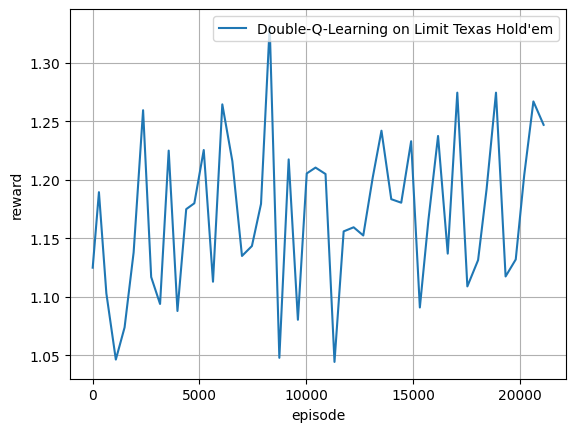

In [10]:
# Make the environments with Limit Texas Hold'em
env = rlcard.make('limit-holdem')
eval_env = rlcard.make('limit-holdem')

# Initialize the DoubleQLearningAgent
DoubleQAgent = DoubleQLearningAgent(num_actions=env.num_actions)

# Set the agents in the environment
env.set_agents([DoubleQAgent, RandomAgent(num_actions=env.num_actions)])
eval_env.set_agents([DoubleQAgent, RandomAgent(num_actions=env.num_actions)])


with Logger("experiments/limit_holdem_doublq_result/") as logger:
    for episode in range(5000):
        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:  # Only use trajectories of the learning agent
            DoubleQAgent.feed(ts)

        # Evaluate the performance every 100 episodes
        if episode % 100 == 0:
            print(f'Episode {episode}')
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    1000
                )[0]
            )

    # Get the paths for the learning curve
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, fig_path, 'Double-Q-Learning on Limit Texas Hold\'em')


### 3.2.4 Conclusion

Despite experimenting with various parameter setups, double Q-Learning seems to struggle with poker, likely due to the inherent complexities of the game, which include partial observability, high dimensionality, and the stochastic nature of outcomes. Since poker is a game of incomplete information where players cannot see their opponents' cards, tabular methods like Double Q-Learning may struggle accurately assess and learn effective strategies. The high variance in rewards, driven by the random dealing of cards and the complex interplay of strategic decisions, further complicates the learning process, leading to instability and poor convergence in the agent's performance. These factors challenge the Double Q-Learning algorithm, causing it to struggle in effectively learning and optimizing strategies in the context of poker. Nonetheless, the agent achieves positive rewards around 1.15, clearly outperforming the random agent.

## 3.3 Extending Standard Double Q-Learning to a Double Deep Q-Network (Double DQN) <a class="anchor" id="3.3"></a>

Moving from standard Double Q-learning with a Double Deep Q-Network (Double DQN) is a logical progression, given the previous algorithms struggle with the complex environment of poker, which features large state spaces. As outlined previoulsy, standard methods may not be sophisticated enough for limit-holdem: By extending the double-Q learning meachnism with the deep learning approach of DQN, we aim to enhance the agent's performance and stability.

### 3.3.1 Advantages of Double DQN Over Standard Double Q-Learning

1. **Reduction of Overestimation Bias**: Double DQN retains the primary advantage of Double Q-learning, significantly reducing the overestimation bias by decoupling the selection of the action from its evaluation. This is done by using two networks, which independently approximate the Q-function, but unlike standard Double Q-learning, they use deep neural networks to manage complex state representations.

2. **Handling Large State Spaces**: Double Q-learning, in its tabular form, struggles with large state spaces due to the curse of dimensionality. Double DQN uses neural networks to approximate the Q-function, allowing it to efficiently handle high-dimensional state spaces found in games like poker.

3. **Improved Generalization**: Neural networks can generalize across similar states due to their function approximation capabilities. This means that in poker, Double DQN can learn strategic similarities across different but related game situations, which tabular methods cannot efficiently accomplish.

4. **Stability and Efficiency**: Double DQN incorporates experience replay and fixed Q-targets. These features help stabilize the learning process by breaking correlations between updates and making learning more efficient through repeated sampling of past experiences. Further, it can perform batch updates using mini-batches from the replay buffer, enhancing learning from a diverse set of experiences.

### 3.3.2 Double Deep Q-Network (Double DQN) Outline

Double DQN extends (sinlge) DQN by using two neural networks, typically referred to as the evaluation network and the target network, to reduce bias in the Q-function approximation:

1. **Neural Network Approximators**:
   - Two neural networks are used, $ Q(s, a; \theta) $ and $ Q(s, a; \theta') $, where $ \theta $ are the parameters of the primary (online) network and $ \theta' $ are the parameters of the target network.
   - These networks have the same architecture but are updated differently to reduce overestimation bias.

2. **Experience Replay**:
   - Like DQN, Double DQN uses a replay buffer to store transitions $ (s, a, r, s') $ and samples random mini-batches from this buffer to update the network, which helps to reduce correlation between sequential updates.

3. **Target Calculation with Double Q-Learning**:
   - Double DQN modifies the target calculation to reduce overestimation by decoupling the selection and evaluation of the action:
     $
     y = r + \gamma Q(s', \arg \max_{a'} Q(s', a'; \theta); \theta')
     $
     Here, $ \arg \max_{a'} Q(s', a'; \theta) $ selects the action using the online network, but the evaluation (action value) is done using the target network $ \theta' $.

4. **Loss Function and Optimization**:
   - The loss function remains the mean-squared error, but the targets are computed as:
     $
     L(\theta) = \mathbb{E}_{(s, a, r, s') \sim \mathcal{D}} \left[ \left( y - Q(s, a; \theta) \right)^2 \right],
     $
     where $ y $ is computed using the Double DQN target.
   - Update the parameters $ \theta $ using an optimizer like Adam on this loss.

5. **Periodic Updates**:
   - Periodically update the parameters $ \theta' $ of the target network to match those of the online network $ \theta $, stabilizing the targets.

### 3.3.3 Application to Poker

In poker, specifically in games like Limit Texas Hold'em, applying Double DQN involves several adaptations to suit the specifics of the game:

1. **State and Action Representation**:
   - The state $ s $ includes numerical representations of the cards, betting history, and other features.
   - Actions (fold, check, call, bet/raise) are represented as the output of the neural network, with each output node providing the Q-value for one action.

2. **Learning from Experience**:
   - As the agent plays hands of poker, it stores the transitions in the replay buffer.
   - It then samples from this buffer to train the network, adjusting the network weights to minimize the difference between the predicted Q-values and the Double DQN targets.

3. **Strategy Adaptation**:
   - Uses an epsilon-greedy policy based on the Q-values to explore different actions and refines the strategy.
   - Decreases epsilon over time to move from exploration to exploitation as the agent's strategy improves.

4. **Network Training**:
   - The neural network is trained using experiences sampled from the replay buffer.
   - Target network is periodically updated to help stabilize the learning process.



### 3.3.4 Implementing Double DQN for Poker

To implement Double DQN, we can utilize the existing `DQNAgent` provided by RLCard. Upon closer examination, the `DQN agent` mentioned in RLCard's documentation is actually a Double DQN agent. Therefore, we can directly call this method and use it with the environment.

Episode 0

----------------------------------------
  episode      |  1
  reward       |  0.763
----------------------------------------
INFO - Step 100, rl-loss: 3.6449947357177734
INFO - Copied model parameters to target network.
INFO - Step 137, rl-loss: 2.985814094543457Episode 100

----------------------------------------
  episode      |  269
  reward       |  -0.0145
----------------------------------------
INFO - Step 267, rl-loss: 2.0871012210845947Episode 200

----------------------------------------
  episode      |  540
  reward       |  0.2385
----------------------------------------
INFO - Step 406, rl-loss: 1.8655469417572021Episode 300

----------------------------------------
  episode      |  812
  reward       |  0.5845
----------------------------------------
INFO - Step 562, rl-loss: 2.28468656539917Episode 400

----------------------------------------
  episode      |  1126
  reward       |  0.741
----------------------------------------
INFO - Step 701, rl-loss: 

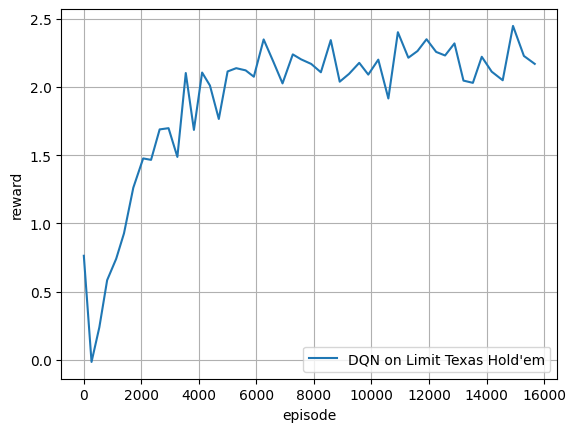

In [10]:
# Make the environment with Limit Texas Hold'em
env = rlcard.make('limit-holdem')
eval_env = rlcard.make('limit-holdem')

# Initialize a DQN agent
TwoDQNagent = DQNAgent(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    mlp_layers=[64, 64],
)

# Set the agents in the environment
env.set_agents([TwoDQNagent, RandomAgent(num_actions=env.num_actions)])
eval_env.set_agents([TwoDQNagent, RandomAgent(num_actions=env.num_actions)])

# Initialize the Logger
with Logger("experiments/limit_holdem_dqn_result/") as logger:
    for episode in range(5000):  # Change the number of episodes based on your computational budget
        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:  # Only use trajectories of the learning agent
            TwoDQNagent.feed(ts)

        # Evaluate the performance every 100 episodes
        if episode % 100 == 0:
            print(f'Episode {episode}')
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    1000  # Reduce the number for quicker evaluations
                )[0]
            )

    # Get the paths for the learning curve
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, fig_path, 'DQN on Limit Texas Hold\'em')



### 3.3.5 Conclusion

By extending standard Double Q-learning to Double DQN, we leverage the strengths of neural networks to handle complex, high-dimensional state spaces while maintaining reduced bias in Q-value estimation. This approach is particularly well-suited for strategic and stochastic environments like poker, where the agent must learn from a vast range of possible situations and actions. We see clear improvments in performance over the tabluar double-Q-learning algorithm: Rewards coverge at a high level after around 100'000 iterations, and are relatively stable.

## 3.4 Deep Fitted Q-Iteration: Combining DQN with Fitted Q-Iteration <a class="anchor" id="3.4"></a>

Next, we propose a Deep Fitted Q-Iteration (DFQI) reinforcement learning approach that combines the strengths of Deep Q-Networks (DQN) with the batch learning capabilities of Fitted Q-Iteration (FQI). This hybrid approach is designed to leverage the deep learning capabilities to approximate complex functions while utilizing batch updates to improve stability and efficiency in learning. While the conceptual and formal background of DQN have already been covered, we briefly outline the Fitted Q-Iteration algorithm and discuss its general advantages, e.g. over a standard DQN approach. We then outline the combined method in more detail.

### 3.4.1 Formal and Conceptual Outline of Fitted Q-Iteration

1. **Initialization**:
   - Begin with an initial Q-function $ Q_0(s, a) $, typically set to zero for all state-action pairs.

2. **Offline Batch Collection**:
   - Collect a dataset $ \mathcal{D} $ of experience tuples $ (s, a, r, s') $. This can be done by running a random policy or a predefined policy to interact with the environment and store the resulting transitions.

3. **Iteration Process**:
   - For each iteration $ k = 1, 2, \ldots, K $:
     - **Compute Target Values**:
       - For each experience tuple $ (s, a, r, s') $ in the dataset $ \mathcal{D} $:
         $
         y = r + \gamma \max_{a'} Q_{k-1}(s', a')
         $
       - These target values represent the estimated future rewards given the current Q-function approximation.
     - **Fit Q-Function**:
       - Use a regression model (e.g., linear regression, neural networks) to fit the Q-function to these target values:
         $
         Q_k = \arg \min_Q \sum_{(s, a, r, s') \in \mathcal{D}} \left( y - Q(s, a) \right)^2
         $
       - The goal is to find the Q-function $ Q_k $ that minimizes the mean squared error between the predicted Q-values and the target values.

4. **Output**:
   - After $ K $ iterations, the final Q-function $ Q_K(s, a) $ is obtained. This function approximates the optimal action-value function based on the experiences in the dataset $ \mathcal{D} $.

Fitted Q-Iteration leverages offline batches of experiences to iteratively refine the action-value function. This approach is particularly useful in scenarios where collecting real-time data is expensive or slow, and it benefits from the stability and efficiency provided by regression-based updates.


### 3.4.2 Advantages of Fitted Q-Iteration

1. **Batch Learning Efficiency**:
   - FQI utilizes batch updates, which means it can efficiently process and learn from large datasets in a single update step.
   - This batch nature allows for more stable updates because the Q-function is fitted using a large set of transitions, reducing the variance that comes from the incremental updates of DQN.

2. **Reduced Overfitting**:
   - By using batch updates FQI can reduce the risk of overfitting compared to e.g. DQN, which continuously updates a deep neural network based on individual transitions or small batches.

3. **Simplicity and Flexibility**:
   - FQI is conceptually simpler and more flexible in terms of the function approximator used. While DQN typically uses neural networks, FQI can leverage a variety of regression models, making it adaptable to the specifics of the problem domain.
   - This flexibility allows for easier integration of domain knowledge and expert features into the learning process.

4. **Data Reuse**:
   - FQI can efficiently reuse the same batch of data for multiple updates, which is beneficial in scenarios where data collection is costly or slow. This is contrasted with DQN, which typically requires ongoing data collection and more complex mechanisms to reuse past data effectively.

### 3.4.3 Applying Deep Fitted Q-Iteration to Poker

In the context of Limit Texas Hold'em, DFQI can be an effective strategy:

1. **Comprehensive State Representation**:
   - In poker, the state includes not only the private and community cards but also the betting history, pot size, player positions, and other strategic information. DFQI uses deep neural networks to encode these high-dimensional states into meaningful representations.

2. **Learning from Rich Experience Batches**:
   - DFQI updates the neural network-based Q-function using large batches of experience data. For poker, this means that the agent can learn effective strategies from extensive sets of past hands, including rare but informative situations like significant bluffs or rare hands.
   - This batch approach allows the agent to refine its strategy based on comprehensive data from various game phases and opponent behaviors.

3. **Strategy Optimization**:
   - By fitting the Q-function across a batch of data, DFQI helps the agent develop a more balanced and robust strategy that considers a wide range of potential actions and outcomes. This is particularly useful in poker, where the effectiveness of a decision (like folding, calling, or raising) often depends on complex and subtle interactions between players.

4. **Adaptation to Opponents**:
   - DFQI’s ability to update from batches of experiences means it can adapt to changes in opponents' strategies by periodically refitting the Q-function using new data reflecting these changes.

5. **Reducing Bias and Variance**:
   - The double Q-learning aspect of DFQI helps reduce the bias in the Q-value estimates, leading to more reliable strategy decisions. Meanwhile, the batch learning aspect helps smooth out the learning process and reduce variance by ensuring that each update is grounded in a comprehensive set of experiences.




### 3.4.4 Implementing Deep Fitted Q-Iteration for Poker

The code builds on the `DQNAgent` implementation from the RLCard library, which leverages Double Deep Q-Network (DDQN) algorithms for training an agent to play Limit Texas Hold'em poker as outlined above. We have extended this implementation by integrating a Fitted Q Iteration component. Specifically, we introduced a `FittedQAgent` that uses `GradientBoostingRegressor` models to approximate Q-values, enhancing the value function approximation. This agent is integrated within the `DQNAgentWithFittedQ` class. The key modifications include the addition of the `FittedQAgent` to perform function approximation and adjustments in the training loop to ensure the models are trained and used correctly. The goal is to combine the stability and learning efficiency of Double DQN with the advanced function approximation capabilities of Fitted Q Iteration, aiming to improve the agent's performance in the complex environment of poker.

The following provides a break down of the algorithm and how the components interact with eachother:

#### Algorithm Overview

The algorithm we've developed combines Double DQN (Deep Q-Network) with Fitted Q Iteration (FQI) for value function approximation. Here's a detailed breakdown:

1. **Double DQN (Deep Q-Network):**
    - **Role:** The Double DQN is responsible for learning the optimal action-value function Q(s, a) using a neural network. It helps the agent make decisions by approximating the expected future rewards for each action in a given state.
    - **Mechanism:**
        - **Q-Network and Target Network:** The agent maintains two neural networks: the Q-Network for predicting Q-values and the Target Network for providing stable target Q-values.
        - **Experience Replay:** Experiences (state, action, reward, next state, done) are stored in a replay memory. The agent samples mini-batches from this memory to update the Q-Network, which helps break the correlation between consecutive experiences.
        - **Double Q-Learning:** To reduce overestimation bias, the Double DQN updates the Q-values using the actions chosen by the Q-Network but evaluates them using the Target Network.

2. **Fitted Q Iteration (FQI):**
    - **Role:** The FQI component approximates the Q-values using supervised learning methods (Gradient Boosting Regressors). It provides a non-parametric way to approximate the Q-values, which can be beneficial for environments with complex dynamics.
    - **Mechanism:**
        - **Gradient Boosting Regressors:** Separate models are trained for each action. These models are used to predict Q-values based on the current state.
        - **Batch Training:** During training, the agent fits these regressors using a batch of experiences. The targets for the regressors are computed using the Bellman equation, incorporating the Q-values predicted by the regressors for the next states.

#### Interaction Between Double DQN and FQI

1. **Experience Collection:**
    - The agent interacts with the Limit Texas Hold'em environment, taking actions based on an epsilon-greedy policy derived from the sum of Q-values from the Double DQN and the Fitted Q models.
    - Experiences (state, action, reward, next state, done) are collected and stored in the replay memory.

2. **Training Process:**
    - **Sampling:** A mini-batch of experiences is sampled from the replay memory.
    - **Fitted Q Iteration:**
        - The `FittedQAgent` uses the batch of experiences to train its Gradient Boosting Regressors. It fits these models by computing targets using the rewards and the discounted Q-values for the next states, as predicted by the regressors.
    - **Double DQN Update:**
        - The Q-values for the next states are predicted using the Fitted Q models.
        - The targets for the Double DQN update are computed using these predicted Q-values, combining the benefits of both approaches.
        - The Q-Network of the Double DQN is updated using these targets, and periodically, the Target Network is updated with the Q-Network's weights.

3. **Action Selection:**
    - During training, actions are selected using an epsilon-greedy policy based on the Q-values predicted by the Double DQN combined with the Q-values from the Fitted Q models.
    - During evaluation, actions are selected greedily based on the combined Q-values.


In [11]:
class FittedQAgent:
    def __init__(self, state_size, action_size, n_estimators=100, max_depth=3, learning_rate=0.1, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma  # Discount factor for future rewards
        self.models = [GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
                       for _ in range(action_size)]
        self.is_fitted = [False] * action_size

    def fit(self, states, actions, rewards, next_states, dones):
        next_action_values = self.predict(next_states)
        targets = rewards + self.gamma * np.max(next_action_values, axis=1) * (1 - dones)

        for action in range(self.action_size):
            action_mask = (actions == action)
            if np.any(action_mask):
                # Ensuring the targets for the fitting are 1D
                action_targets = targets[action_mask]
                self.models[action].fit(states[action_mask], action_targets)
                self.is_fitted[action] = True

    def predict(self, states):
        action_values = np.zeros((states.shape[0], self.action_size))
        for action in range(self.action_size):
            if self.is_fitted[action]:
                action_values[:, action] = self.models[action].predict(states)
            else:
                # If not fitted, predict zeros
                action_values[:, action] = np.zeros(states.shape[0])
        return action_values

    def act(self, state, epsilon=0.1):
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size)
        else:
            q_values = self.predict(state.reshape(1, -1))[0]
            return np.argmax(q_values)

Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done', 'legal_actions'])

class DQNAgentWithFittedQ:
    def __init__(self,
                 replay_memory_size=20000,
                 replay_memory_init_size=100,
                 update_target_estimator_every=1000,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=32,
                 num_actions=2,
                 state_shape=None,
                 train_every=1,
                 mlp_layers=None,
                 learning_rate=0.00005,
                 device=None,
                 save_path=None,
                 save_every=float('inf'),
                 fitted_q_iterations=100,  # Number of iterations for fitting Q
                 max_depth=3,  # Max depth for Gradient Boosting
                 estimator_lr=0.1):  # Learning rate for Gradient Boosting

        # Initialization code...
        self.use_raw = False
        self.replay_memory_init_size = replay_memory_init_size
        self.update_target_estimator_every = update_target_estimator_every
        self.discount_factor = discount_factor
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.num_actions = num_actions
        self.train_every = train_every

        # Torch device
        if device is None:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        # Total timesteps
        self.total_t = 0

        # Total training step
        self.train_t = 0

        # The epsilon decay scheduler
        self.epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

        # Create estimators
        self.q_estimator = Estimator(num_actions=num_actions, learning_rate=learning_rate, state_shape=state_shape, mlp_layers=mlp_layers, device=self.device)
        self.target_estimator = Estimator(num_actions=num_actions, learning_rate=learning_rate, state_shape=state_shape, mlp_layers=mlp_layers, device=self.device)

        # Fitted Q agent
        self.fitted_q_agent = FittedQAgent(state_size=np.prod(state_shape), action_size=num_actions, n_estimators=fitted_q_iterations, max_depth=max_depth, learning_rate=estimator_lr)

        # Create replay memory
        self.memory = Memory(replay_memory_size, batch_size)

        # Checkpoint saving parameters
        self.save_path = save_path
        self.save_every = save_every

    def feed(self, ts):
        (state, action, reward, next_state, done) = tuple(ts)


        self.feed_memory(state['obs'], action, reward, next_state['obs'], list(next_state['legal_actions'].keys()), done)
        self.total_t += 1
        tmp = self.total_t - self.replay_memory_init_size
        if tmp >= 0 and tmp % self.train_every == 0:
            if len(self.memory.memory) >= self.batch_size:  # Ensure there's enough data
                self.train()


    def train(self):
        if len(self.memory.memory) < self.batch_size:
            return  # Not enough data to train

        state_batch, action_batch, reward_batch, next_state_batch, done_batch, _ = self.memory.sample()

        states = np.vstack(state_batch)
        next_states = np.vstack(next_state_batch)

        # Training the Fitted Q model
        self.fitted_q_agent.fit(states, action_batch, reward_batch, next_states, done_batch)

        # Prepare the batch for DQN update
        q_values_next = self.fitted_q_agent.predict(next_states)
        q_values_next_target = self.target_estimator.predict_nograd(next_state_batch)
        target_batch = reward_batch + (1 - done_batch.astype(np.float32)) * self.discount_factor * np.max(q_values_next_target, axis=1)

        # Update the DQN
        loss = self.q_estimator.update(state_batch, action_batch, target_batch)
        print(f'\rINFO - Step {self.total_t}, rl-loss: {loss}', end='')

        if self.train_t % self.update_target_estimator_every == 0:
            self.target_estimator = deepcopy(self.q_estimator)
            print("\nINFO - Copied model parameters to target network.")

        self.train_t += 1

        if self.save_path and self.train_t % self.save_every == 0:
            self.save_checkpoint(self.save_path)
            print("\nINFO - Saved model checkpoint.")



    def step(self, state):
        q_values = self.predict(state)
        epsilon = self.epsilons[min(self.total_t, self.epsilon_decay_steps-1)]
        legal_actions = list(state['legal_actions'].keys())
        probs = np.ones(len(legal_actions), dtype=float) * epsilon / len(legal_actions)
        best_action_idx = legal_actions.index(np.argmax(q_values))
        probs[best_action_idx] += (1.0 - epsilon)
        action_idx = np.random.choice(np.arange(len(probs)), p=probs)
        return legal_actions[action_idx]

    def eval_step(self, state):
        q_values = self.predict(state)
        best_action = np.argmax(q_values)
        info = {}
        info['values'] = {state['raw_legal_actions'][i]: float(q_values[list(state['legal_actions'].keys())[i]]) for i in range(len(state['legal_actions']))}
        return best_action, info

    def predict(self, state):
        q_values = self.q_estimator.predict_nograd(np.expand_dims(state['obs'], 0))[0]
        masked_q_values = -np.inf * np.ones(self.num_actions, dtype=float)
        legal_actions = list(state['legal_actions'].keys())
        masked_q_values[legal_actions] = q_values[legal_actions]
        return masked_q_values

    def feed_memory(self, state, action, reward, next_state, legal_actions, done):
        self.memory.save(state, action, reward, next_state, legal_actions, done)

    def set_device(self, device):
        self.device = device
        self.q_estimator.device = device
        self.target_estimator.device = device

    def checkpoint_attributes(self):
        return {
            'agent_type': 'DQNAgentWithFittedQ',
            'q_estimator': self.q_estimator.checkpoint_attributes(),
            'memory': self.memory.checkpoint_attributes(),
            'total_t': self.total_t,
            'train_t': self.train_t,
            'replay_memory_init_size': self.replay_memory_init_size,
            'update_target_estimator_every': self.update_target_estimator_every,
            'discount_factor': self.discount_factor,
            'epsilon_start': self.epsilons.min(),
            'epsilon_end': self.epsilons.max(),
            'epsilon_decay_steps': self.epsilon_decay_steps,
            'batch_size': self.batch_size,
            'num_actions': self.num_actions,
            'train_every': self.train_every,
            'device': self.device,
            'save_path': self.save_path,
            'save_every': self.save_every
        }

    @classmethod
    def from_checkpoint(cls, checkpoint):
        print("\nINFO - Restoring model from checkpoint...")
        agent_instance = cls(
            replay_memory_size=checkpoint['memory']['memory_size'],
            replay_memory_init_size=checkpoint['replay_memory_init_size'],
            update_target_estimator_every=checkpoint['update_target_estimator_every'],
            discount_factor=checkpoint['discount_factor'],
            epsilon_start=checkpoint['epsilon_start'],
            epsilon_end=checkpoint['epsilon_end'],
            epsilon_decay_steps=checkpoint['epsilon_decay_steps'],
            batch_size=checkpoint['batch_size'],
            num_actions=checkpoint['num_actions'],
            state_shape=checkpoint['q_estimator']['state_shape'],
            train_every=checkpoint['train_every'],
            mlp_layers=checkpoint['q_estimator']['mlp_layers'],
            learning_rate=checkpoint['q_estimator']['learning_rate'],
            device=checkpoint['device'],
            save_path=checkpoint['save_path'],
            save_every=checkpoint['save_every'],
        )

        agent_instance.total_t = checkpoint['total_t']
        agent_instance.train_t = checkpoint['train_t']

        agent_instance.q_estimator = Estimator.from_checkpoint(checkpoint['q_estimator'])
        agent_instance.target_estimator = deepcopy(agent_instance.q_estimator)
        agent_instance.memory = Memory.from_checkpoint(checkpoint['memory'])

        return agent_instance

    def save_checkpoint(self, path, filename='checkpoint_dqn_with_fittedq.pt'):
        torch.save(self.checkpoint_attributes(), os.path.join(path, filename))


class Estimator(object):
    def __init__(self, num_actions=2, learning_rate=0.001, state_shape=None, mlp_layers=None, device=None):
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.state_shape = state_shape
        self.mlp_layers = mlp_layers
        self.device = device

        qnet = EstimatorNetwork(num_actions, state_shape, mlp_layers)
        qnet = qnet.to(self.device)
        self.qnet = qnet
        self.qnet.eval()

        for p in self.qnet.parameters():
            if len(p.data.shape) > 1:
                nn.init.xavier_uniform_(p.data)

        self.mse_loss = nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.Adam(self.qnet.parameters(), lr=self.learning_rate)

    def predict_nograd(self, s):
        with torch.no_grad():
            s = torch.from_numpy(s).float().to(self.device)
            q_as = self.qnet(s).cpu().numpy()
        return q_as

    def update(self, s, a, y):
        self.optimizer.zero_grad()
        self.qnet.train()
        s = torch.from_numpy(s).float().to(self.device)
        a = torch.from_numpy(a).long().to(self.device)
        y = torch.from_numpy(y).float().to(self.device)

        q_as = self.qnet(s)
        Q = torch.gather(q_as, dim=-1, index=a.unsqueeze(-1)).squeeze(-1)

        batch_loss = self.mse_loss(Q, y)
        batch_loss.backward()
        self.optimizer.step()
        batch_loss = batch_loss.item()

        self.qnet.eval()
        return batch_loss

    def checkpoint_attributes(self):
        return {
            'qnet': self.qnet.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'num_actions': self.num_actions,
            'learning_rate': self.learning_rate,
            'state_shape': self.state_shape,
            'mlp_layers': self.mlp_layers,
            'device': self.device
        }

    @classmethod
    def from_checkpoint(cls, checkpoint):
        estimator = cls(
            num_actions=checkpoint['num_actions'],
            learning_rate=checkpoint['learning_rate'],
            state_shape=checkpoint['state_shape'],
            mlp_layers=checkpoint['mlp_layers'],
            device=checkpoint['device']
        )

        estimator.qnet.load_state_dict(checkpoint['qnet'])
        estimator.optimizer.load_state_dict(checkpoint['optimizer'])
        return estimator


class EstimatorNetwork(nn.Module):
    def __init__(self, num_actions=2, state_shape=None, mlp_layers=None):
        super(EstimatorNetwork, self).__init__()
        self.num_actions = num_actions
        self.state_shape = state_shape
        self.mlp_layers = mlp_layers

        layer_dims = [np.prod(self.state_shape)] + self.mlp_layers
        fc = [nn.Flatten()]
        fc.append(nn.BatchNorm1d(layer_dims[0]))
        for i in range(len(layer_dims) - 1):
            fc.append(nn.Linear(layer_dims[i], layer_dims[i + 1], bias=True))
            fc.append(nn.Tanh())
        fc.append(nn.Linear(layer_dims[-1], self.num_actions, bias=True))
        self.fc_layers = nn.Sequential(*fc)

    def forward(self, s):
        return self.fc_layers(s)

class Memory(object):
    def __init__(self, memory_size, batch_size):
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = []

    def save(self, state, action, reward, next_state, legal_actions, done):
        if len(self.memory) == self.memory_size:
            self.memory.pop(0)
        transition = Transition(state, action, reward, next_state, done, legal_actions)
        self.memory.append(transition)

    def sample(self):
        samples = random.sample(self.memory, self.batch_size)
        samples = tuple(zip(*samples))
        return tuple(map(np.array, samples[:-1])) + (samples[-1],)

    def checkpoint_attributes(self):
        return {
            'memory_size': self.memory_size,
            'batch_size': self.batch_size,
            'memory': self.memory
        }

    @classmethod
    def from_checkpoint(cls, checkpoint):
        instance = cls(checkpoint['memory_size'], checkpoint['batch_size'])
        instance.memory = checkpoint['memory']
        return instance


Episode 0

----------------------------------------
  episode      |  4
  reward       |  -0.1035
----------------------------------------
INFO - Step 100, rl-loss: 9.582218170166016
INFO - Copied model parameters to target network.
INFO - Step 147, rl-loss: 6.417984962463379Episode 100

----------------------------------------
  episode      |  294
  reward       |  0.867
----------------------------------------
INFO - Step 292, rl-loss: 2.869814157485962Episode 200

----------------------------------------
  episode      |  592
  reward       |  0.7535
----------------------------------------
INFO - Step 442, rl-loss: 0.7012593746185303Episode 300

----------------------------------------
  episode      |  895
  reward       |  1.1255
----------------------------------------
INFO - Step 569, rl-loss: 2.6689705848693848Episode 400

----------------------------------------
  episode      |  1162
  reward       |  1.173
----------------------------------------
INFO - Step 728, rl-loss: 

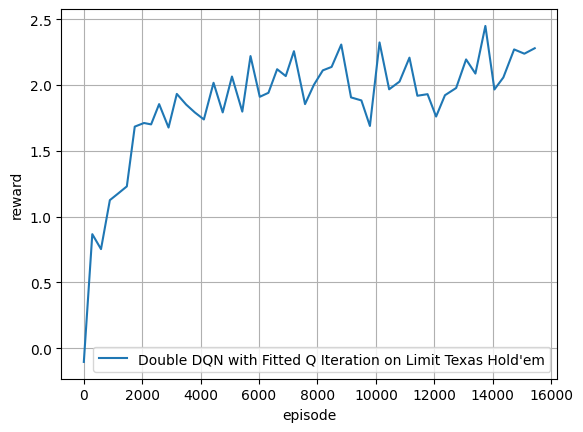

In [12]:
# Make the environment with Limit Texas Hold'em
env = rlcard.make('limit-holdem')
eval_env = rlcard.make('limit-holdem')

# Initialize the Double DQN + Fitted Q Iteration agent
FittedDQagent = DQNAgentWithFittedQ(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    mlp_layers=[64, 64],
)

# Set the agents in the environment
env.set_agents([FittedDQagent, RandomAgent(num_actions=env.num_actions)])
eval_env.set_agents([FittedDQagent, RandomAgent(num_actions=env.num_actions)])

# Initialize the Logger
with Logger("experiments/limit_holdem_dqn_with_fittedq_result/") as logger:
    for episode in range(5000): 
        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:  # Only use trajectories of the learning agent
            FittedDQagent.feed(ts)

        # Evaluate the performance every 100 episodes
        if episode % 100 == 0:
            print(f'Episode {episode}')
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    1000  
                )[0]
            )

    # Get the paths for the learning curve
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, fig_path, 'Double DQN with Fitted Q Iteration on Limit Texas Hold\'em')


### 3.4.5 Conclusion

Deep Fitted Q-Iteration for poker combines the depth and flexibility of neural network-based function approximation with the stability and efficiency of batch learning from FQI. This approach is well-suited to the strategic and probabilistic aspects of poker. The implementation performs well against the RandomAgent and reaches reward levels of up to 2.50. However, it is important to note that training is quite slow and more computationally expensive than for the methods we have encoutered before.

## 3.5 Policy-Based Learning in Poker <a class="anchor" id="3.5"></a>

 Policy-Based Learning focuses on directly optimizing the policy — a mapping from states to actions — which is more natural and often more effective for decision-making problems where the optimal strategy involves randomness and deception, such as in poker.

### 3.5.1 Key Points of Policy-Based Learning:

1. **Direct Policy Optimization**: Policy-based methods optimize the policy directly without requiring a separate step of value function estimation. This is particularly useful in poker, where directly learning the best action (like whether to fold, call, or raise) is more intuitive and can be more efficient than learning a value function first.

2. **Handling Stochastic Policies**: Poker often requires mixed strategies for optimal play, where actions are chosen with specific probabilities. Policy-based methods can naturally learn these stochastic policies, potentially enabling the agent to bluff or change tactics in ways that are harder to exploit.

3. **Applicability to Continuous and High-Dimensional Actions**: Policy-based learning can handle high-dimensional action spaces more gracefully than value-based methods.

4. **Gradient Ascent Optimization**: Using gradient ascent to improve the policy allows these methods to efficiently navigate the high-dimensional policy space, which is important in poker where the decision space can be vast due to the combination of betting rounds and possible opponent strategies.

5. **Robustness to Model Misspecification**: Poker is a game of incomplete information and dynamic changes. Policy-based methods, by focusing on the policy itself, tend to be more robust to changes in the environment and opponent behavior, adapting more fluidly than methods that require a fixed model of rewards.

### 3.5.2 Introducing Advantage Actor-Critic (A2C) for Texas Hold'em

Advantage Actor-Critic (A2C) is an enhanced policy-based method that introduces a more stable and efficient way to train the policy by using the advantage function. The advantage function $ A(s, a) = Q(s, a) - V(s) $ measures how much better taking action $ a $ is compared to the average value of the state $ s $. This approach helps focus the learning on the most promising actions, reducing variance and improving the convergence speed.

### 3.5.3 A2C in Poker:

In Texas Hold'em and other poker variants, A2C can help the agent develop strategies that balance the potential rewards of different actions more effectively than simpler methods:

1. **Balanced Strategy Development**: By using the advantage function, A2C helps the agent learn when to take actions that are significantly better than the average, aiding in the development of balanced bluffing and betting strategies.

2. **Efficient Use of Experience**: A2C uses experiences more efficiently by focusing updates on actions that have the most to teach the agent — those with the highest advantage. This is key in poker, where many situations recur with slight variations.

3. **Faster Learning**: The separation of the policy (actor) and value estimates (critic) allows A2C to learn more effectively, with the critic providing a stable baseline that reduces the variance of updates to the actor.

4. **Handling Sparse Rewards**: In poker, rewards (like winning a hand) are sparse and delayed until the end of a hand. A2C’s approach, which balances immediate feedback (rewards) with longer-term value estimates, helps attribute rewards to actions more accurately throughout a hand.


### 3.5.4 Implementing Advantage Actor-Critic (A2C) with Fitted Q Iteration for Poker

In our implementation of the Advantage Actor-Critic (A2C) framework, we introduce an adaptation by replacing the typical neural network-based critic with a suite of Gradient Boosting Regressors, forming the core of our Fitted Q Iteration method. This approach aims to leverage the strengths of ensemble methods for more precise Q-value approximations.

#### Detailed Breakdown of the Implementation:

1. **Data Collection:**
   - **Process:** We accumulate transitions in the form $(s, a, r, s', \text{done})$ within a deque-based memory buffer. This setup helps in managing experience replay, essential for learning from a richer history of past actions.
   - **Utility:** By storing these transitions, we enable batch learning from diverse past experiences, reducing temporal correlations and enhancing the robustness of our learning updates.

2. **Learning:**
   - **Critic Training:**
     - **Role and Structure:** Each action in the poker game has a corresponding Gradient Boosting Regressor in the critic. These models are independently updated using their respective experiences.
     - **Mechanism:** For each action $a$, its regressor is trained on states where $a$ was taken, using targets formed by the Bellman equation:
       $
       y = r + \gamma \max_{a'} Q(s', a')
       $
       where $s'$ is the subsequent state and $\max_{a'} Q(s', a')$ is derived from the critic's current predictions, providing a lookahead to enhance current decision-making.
   - **Actor Training:**
     - **Gradient Update:** The Actor network updates its policy parameters $\theta$ by ascending the gradient of the expected reward, which is estimated using:
       $
       \nabla_{\theta} J(\theta) = \mathbb{E}[\log \pi(a|s) A(s, a)]
       $
       Here, $A(s, a) = Q(s, a) - V(s)$ is approximated as:
       $
       A(s, a) = r + \gamma \max_{a'} Q(s', a') (1 - \text{done}) - Q(s, a)
       $
       with $Q(s, a)$ directly provided by the critic’s prediction for action $a$ at state $s$. This forms the advantage, guiding the policy toward more rewarding actions.
   - **Synchronization:** The updates to both the Actor and the Critic are conducted in lockstep, with the Actor improving its policy based on the current state-value assessments from the Critic, ensuring a cohesive advancement toward optimal strategies.

3. **Policy Execution:**
   - **Exploration vs. Exploitation:** During training, actions are chosen based on a probabilistic policy derived from the Actor’s outputs, ensuring exploration through stochastic behavior. For evaluation, the policy becomes deterministic, selecting actions with the highest probability to assess performance without exploratory noise.
   - **Execution Dynamics:** The agent's interaction with the poker environment during these phases helps in fine-tuning its strategy, balancing immediate rewards with long-term strategic planning.

#### Note on Gradient Boosting Regressors for the Critic:

By using Gradient Boosting Regressors, the critic may be able to more accurately handle the dependencies and variability in poker states and actions. This ensemble approach allows each model to focus on predicting outcomes for a specific action, potentially enhancing the overall precision in Q-value approximation. In summary, we try to blend policy gradient techniques with ensemble value function estimation.

Again, our code implementation follows to strucutre of an RLcard agent, to allow for smooth interaction with the provided environments.

In [1]:
# Actor instance
class Actor(nn.Module):
    # Create the actor network based on pytorch
    def __init__(self, state_size, action_size, hidden_size=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return self.softmax(x)

# Fitted-Q-Agent based on previous method
class FittedQAgent:
    def __init__(self, state_size, action_size, estimator_learning_rate=0.01, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.models = [GradientBoostingRegressor(learning_rate=estimator_learning_rate) for _ in range(action_size)]
        self.is_fitted = [False] * action_size

    def fit(self, states, actions, rewards, next_states, dones):
        next_action_values = np.zeros((len(next_states), self.action_size))
        for action in range(self.action_size):
            if self.is_fitted[action]:
                next_action_values[:, action] = self.models[action].predict(next_states)

        targets = rewards + self.gamma * np.max(next_action_values, axis=1) * (1 - dones)

        for action in range(self.action_size):
            action_mask = (actions == action)
            if np.any(action_mask):
                self.models[action].fit(states[action_mask], targets[action_mask])
                self.is_fitted[action] = True

    def predict(self, states):
        action_values = np.zeros((len(states), self.action_size))
        for action in range(self.action_size):
            if self.is_fitted[action]:
                action_values[:, action] = self.models[action].predict(states)
            else:
                action_values[:, action] = 0
        return action_values

# Building the agent using the standard functions for an RLcard agent
class A2CAgentWithFittedQ:
    def __init__(self, num_actions, state_size, hidden_size=128, gamma=0.99, lr=1e-4, batch_size=64):
        self.actor = Actor(state_size, num_actions, hidden_size)
        self.critic = FittedQAgent(state_size, num_actions, estimator_learning_rate=0.01, gamma=gamma)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = deque(maxlen=2000)
        self.num_actions = num_actions
        self.use_raw = False

    def feed(self, ts):
        (state, action, reward, next_state, done) = ts

        # Ensure only the numeric observation part is used, not the full dictionary
        state_obs = state['obs']
        next_state_obs = next_state['obs']

        # Append transition to memory
        self.memory.append((state_obs, action, reward, next_state_obs, done))

        if len(self.memory) >= self.batch_size:
            self.learn()


    def learn(self):
        # Check if we have enough samples to form a batch
        if len(self.memory) < self.batch_size:
            return

        # Randomly sample a batch of experiences from memory
        experiences = random.sample(self.memory, self.batch_size)

        # Unzip the experiences into separate lists
        states, actions, rewards, next_states, dones = zip(*experiences)

        # Convert these lists into numpy arrays
        states = np.vstack(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.vstack(next_states)
        dones = np.array(dones)

        # Fit the critic model
        self.critic.fit(states, actions, rewards, next_states, dones)

        # Update the actor model by policy gradient
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        probs = self.actor(states)
        dist = torch.distributions.Categorical(probs)
        log_probs = dist.log_prob(actions)

        # Use critic to calculate the value function Q
        q_values = torch.tensor(self.critic.predict(states), dtype=torch.float32)
        q_values = q_values.gather(1, actions.unsqueeze(-1)).squeeze(-1)

        advantages = torch.tensor(rewards, dtype=torch.float32) + self.gamma * torch.tensor(np.max(self.critic.predict(next_states), axis=1), dtype=torch.float32) * (1 - torch.tensor(dones, dtype=torch.float32)) - q_values

        actor_loss = -(log_probs * advantages.detach()).mean()
        self.optimizer.zero_grad()
        actor_loss.backward()
        self.optimizer.step()

        # Clear the memory after learning
        self.memory.clear()


    def step(self, state):
        state_tensor = torch.tensor(state['obs'], dtype=torch.float32)
        probs = self.actor(state_tensor).detach().numpy()
        action = np.random.choice(self.num_actions, p=probs)
        return action

    def eval_step(self, state):
        state_tensor = torch.tensor(state['obs'], dtype=torch.float32)
        probs = self.actor(state_tensor).detach().numpy()
        action = np.argmax(probs)
        return action, {}

    def save(self, path):
        torch.save(self.actor.state_dict(), path + '_actor.pth')
        # Save the Fitted Q models
        for idx, model in enumerate(self.critic.models):
            model_path = path + f'_critic_model_{idx}.joblib'
            joblib.dump(model, model_path)

    def load(self, path):
        self.actor.load_state_dict(torch.load(path + '_actor.pth'))
        for idx, model in enumerate(self.critic.models):
            model_path = path + f'_critic_model_{idx}.joblib'
            self.critic.models[idx] = joblib.load(model_path)
            self.critic.is_fitted[idx] = True



Episode 0

----------------------------------------
  episode      |  1
  reward       |  -0.156
----------------------------------------
Episode 100

----------------------------------------
  episode      |  220
  reward       |  -0.053
----------------------------------------
Episode 200

----------------------------------------
  episode      |  495
  reward       |  0.101
----------------------------------------
Episode 300

----------------------------------------
  episode      |  723
  reward       |  0.2265
----------------------------------------
Episode 400

----------------------------------------
  episode      |  1030
  reward       |  0.252
----------------------------------------
Episode 500

----------------------------------------
  episode      |  1262
  reward       |  0.3285
----------------------------------------
Episode 600

----------------------------------------
  episode      |  1506
  reward       |  0.1775
----------------------------------------
Episode 7

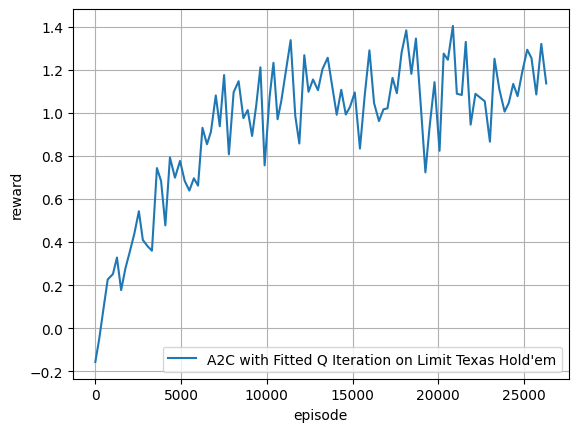

In [6]:
# Initialize environments
env = rlcard.make('limit-holdem')
eval_env = rlcard.make('limit-holdem')

# Use the agent created above
A2Cagent = A2CAgentWithFittedQ(num_actions=env.num_actions, state_size=env.state_shape[0][0], hidden_size=128, gamma=0.99, lr=0.0001, batch_size=64)
env.set_agents([A2Cagent, RandomAgent(num_actions=env.num_actions)])
eval_env.set_agents([A2Cagent, RandomAgent(num_actions=env.num_actions)])


# Initialize the Logger
with Logger("experiments/limit_holdem_a2c_with_fittedq_result/") as logger:
    for episode in range(10000):
        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:  # Only use trajectories of the learning agent
            A2Cagent.feed(ts)

        # Evaluate the performance every 100 episodes
        if episode % 100 == 0:
            print(f'Episode {episode}')
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    1000  
                )[0]
            )

    # Get the paths for the learning curve
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, fig_path, 'A2C with Fitted Q Iteration on Limit Texas Hold\'em')



### 3.5.4 Conclusion

While the A2C agent does exhibit some learning behaviour, it performs worse than some of the methods we have seen perviously. Selecting a range of different paramter setups did not aid the results. There are a few potential reasons why an A2C agent might perform worse on Limit Hold'em compared to e.g. the DQN agent. A2C, which combines policy gradients with value function estimation, may struggle with the high variance in reward signals inherent in poker, leading to unstable updates. Nonetheless, the A2C agent clearly outperforms the random agent, reaching reward levels of up to 1.4.

## 3.6 Neural Fictitious Self-Play <a class="anchor" id="3.6"></a>
Heinrich, J., & Silver, D. (2016). Deep Reinforcement Learning from Self-Play in Imperfect-Information Games. arXiv preprint arXiv:1603.01121.

The Neural Fictitious Self-Play (NFSP) agent represents a hybrid approach within the reinforcement learning framework, combining both policy-based and value-based methods in a model-free setting. Developed by Heinrich and Silver (2016), NFSP aims to approximate Nash equilibria in imperfect-information games without relying on prior domain knowledge. The agent employs two neural networks: one trained via supervised learning to approximate the agent's average strategy (policy-based) and another trained via off-policy Q-learning to predict action values (value-based). By learning directly from self-play experiences, NFSP effectively integrates these components, making it a robust solution for complex, real-world scenarios such as poker, where strategic decision-making is crucial.


### 3.6.1 Explanation of Key Points of NFSP:

Neural Fictitious Self-Play (NFSP) uniquely combines elements of fictitious self-play with deep learning techniques to achieve scalable, domain-independent learning. The following outlines the algorithm:

1. **Dual Neural Networks:**
   NFSP employs two neural networks: an action-value network $ Q(s, a | \theta^Q) $ and an average-policy network $ \Pi(s, a | \theta^\Pi) $.

   - **Action-Value Network (Q-Network):**
     This network is trained using reinforcement learning to predict the expected return of taking action $ a $ in state $ s $. It approximates the Q-function:
     $
     Q(s, a) = \mathbb{E}_{\pi} [G_t | S_t = s, A_t = a]
     $
     where $ G_t $ is the cumulative future reward.

   - **Average-Policy Network (Policy Network):**
     This network is trained using supervised learning to predict the agent's average strategy based on historical behavior:
     $
     \Pi(s, a) \approx \pi(s, a)
     $
     where $ \pi(s, a) $ is the probability of taking action $ a $ in state $ s $ according to the agent’s average strategy.

2. **Reinforcement Learning Memory (MRL):**
   The agent stores its experiences of state transitions, actions, and rewards in a memory buffer $ M_{RL} $. These experiences are used to train the Q-network using Q-learning:
   $
   L(\theta^Q) = \mathbb{E}_{(s, a, r, s') \sim M_{RL}} \left[ (r + \gamma \max_{a'} Q(s', a' | \theta^{Q'}) - Q(s, a | \theta^Q))^2 \right]
   $
   where $ \gamma $ is the discount factor and $ \theta^{Q'} $ are the parameters of a target network periodically updated to stabilize training.

3. **Supervised Learning Memory (MSL):**
   The agent also stores its own actions and states in another memory buffer $ M_{SL} $. This data is used to train the policy network using supervised learning:
   $
   L(\theta^\Pi) = \mathbb{E}_{(s, a) \sim M_{SL}} \left[ -\log \Pi(a | s, \theta^\Pi) \right]
   $

4. **Anticipatory Dynamics:**
   To ensure that the agent can learn an effective strategy while adapting to opponents, NFSP uses anticipatory dynamics with an anticipatory parameter $ \eta $. The agent’s behavior policy is a mixture of its average policy and its best response:
   $
   \sigma(s) = \begin{cases}
   \epsilon\text{-greedy}(Q) & \text{with probability } \eta \\
   \Pi(s) & \text{with probability } 1 - \eta
   \end{cases}
   $
   where $ \epsilon $-greedy(Q) is a policy that selects a random action with probability $ \epsilon $ and the action with the highest Q-value otherwise.

5. **Reservoir Sampling:**
   NFSP uses reservoir sampling to maintain a representative sample of historical data in $ M_{SL} $. This technique ensures that the supervised learning memory contains a diverse set of experiences, which helps in stabilizing the training process.

6. **Training Process:**
   During training, the agent alternates between using the Q-network to learn an approximate best response and using the policy network to update its average strategy. The training process can be summarized as follows:
   - Generate self-play experiences and store them in $ M_{RL} $ and $ M_{SL} $.
   - Update the Q-network parameters $ \theta^Q $ by minimizing the Q-learning loss.
   - Update the policy network parameters $ \theta^\Pi $ by minimizing the supervised learning loss.
   - Periodically evaluate and update the target network parameters $ \theta^{Q'} $.

#### Mathematical Formulation:

The loss functions for the two neural networks are given by:
1. **Q-Network Loss (Reinforcement Learning):**
   $
   L(\theta^Q) = \mathbb{E}_{(s, a, r, s') \sim M_{RL}} \left[ (r + \gamma \max_{a'} Q(s', a' | \theta^{Q'}) - Q(s, a | \theta^Q))^2 \right]
   $

2. **Policy Network Loss (Supervised Learning):**
   $
   L(\theta^\Pi) = \mathbb{E}_{(s, a) \sim M_{SL}} \left[ -\log \Pi(a | s, \theta^\Pi) \right]
   $


### 3.6.2 Code Implementation

RLcard offers a NSFP agent through the API. Hence, we created the environment and initialized the NFSP agent with optimal parameters from the paper. The agent's neural networks were configured with four hidden layers of 1024, 512, 1024, and 512 neurons using ReLU activations. We set the reinforcement learning memory size to 600,000 and the supervised learning memory to 30 million, using exponentially-averaged reservoir sampling. The Q-network and policy network learning rates were set to 0.1 and 0.01 respectively, with mini-batch sizes of 256. The exploration rate (epsilon) started at 0.08, decaying to 0, and the anticipatory parameter was set to 0.1. During training, the agent performed two gradient updates every 256 steps, periodically evaluated against a stronger opponent to monitor performance. This setup ensured the agent's training followed the best practices identified in the NFSP paper.


----------------------------------------
  episode      |  1
  reward       |  0.1995
----------------------------------------
Episode 0, Reward: 0.1995

----------------------------------------
  episode      |  306
  reward       |  0.0455
----------------------------------------
Episode 100, Reward: 0.0455

----------------------------------------
  episode      |  663
  reward       |  0.0135
----------------------------------------
Episode 200, Reward: 0.0135

----------------------------------------
  episode      |  977
  reward       |  0.1035
----------------------------------------
Episode 300, Reward: 0.1035

----------------------------------------
  episode      |  1265
  reward       |  0.205
----------------------------------------
Episode 400, Reward: 0.205

----------------------------------------
  episode      |  1559
  reward       |  -0.023
----------------------------------------
Episode 500, Reward: -0.023

----------------------------------------
  episode     

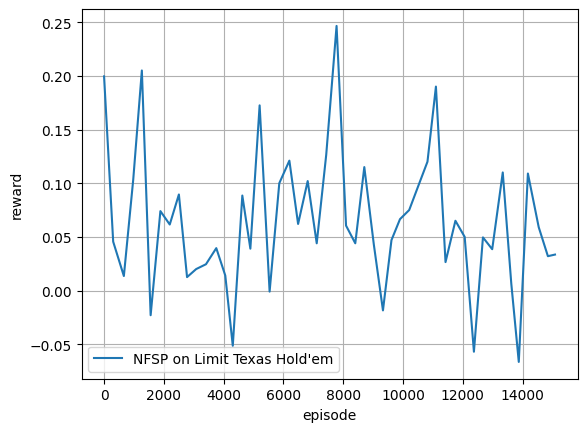

In [5]:
# Make the environment with Limit Texas Hold'em
env = rlcard.make('limit-holdem')
eval_env = rlcard.make('limit-holdem')

# Initialize the NFSP Agent with optimal parameters from the paper
NFSPagent = NFSPAgent(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    hidden_layers_sizes=[1024, 512, 1024, 512],  # Sizes of the hidden layers for the MLP in the average network
    reservoir_buffer_capacity=30000000,  # Capacity of the reservoir buffer
    anticipatory_param=0.1,  # Anticipatory parameter
    batch_size=256,  # Batch size for supervised learning
    train_every=1,  # Train the network every X steps
    rl_learning_rate=0.1,  # Learning rate for the RL component
    sl_learning_rate=0.01,  # Learning rate for the SL component
    min_buffer_size_to_learn=1000,  # Minimum replay buffer size before learning starts
    q_replay_memory_size=600000,  # Size of the replay memory
    q_replay_memory_init_size=1000,  # Initial size of replay memory
    q_update_target_estimator_every=1000,  # Update the target estimator every X steps
    q_discount_factor=0.99,  # Discount factor (gamma)
    q_epsilon_start=0.08,  # Starting epsilon for exploration
    q_epsilon_end=0,  # Final epsilon for exploration
    q_epsilon_decay_steps=10000,  # Number of steps to decay epsilon
    q_batch_size=256,  # Batch size for Q-learning
    q_train_every=1,  # Train Q every X steps
    q_mlp_layers=[1024, 512, 1024, 512],  # Sizes of the hidden layers for the MLP in the Q network
    evaluate_with='average_policy'  # Evaluate with average policy
)

# Initialize a stronger DQN Agent for training
#dqn_agent = DQNAgent(
#    num_actions=env.num_actions,
#    state_shape=env.state_shape[0],
#    mlp_layers=[512, 512],
#    replay_memory_size=50000,
#    replay_memory_init_size=1000,
#    update_target_estimator_every=1000,
#    discount_factor=0.99,
#    epsilon_start=1.0,
#    epsilon_end=0.1,
#    epsilon_decay_steps=20000,
#    batch_size=32,
#    learning_rate=0.0001
#)

# Set the agents in the environment (RandomAgent)
env.set_agents([NFSPagent, RandomAgent(num_actions=env.num_actions)])
eval_env.set_agents([NFSPagent, RandomAgent(num_actions=env.num_actions)])


# Initialize the Logger
with Logger("experiments/limit_holdem_nfsp_result/") as logger:
    for episode in range(5000):  # Increase the number of episodes
        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:  # Only use trajectories of the learning agent
            NFSPagent.feed(ts)

        # Evaluate the performance every 100 episodes
        if episode % 100 == 0:
            reward = tournament(
                eval_env,
                1000  # Number of games to play when evaluating
            )[0]
            logger.log_performance(env.timestep, reward)
            print(f'Episode {episode}, Reward: {reward}')

    # Get the paths for the learning curve
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, fig_path, 'NFSP on Limit Texas Hold\'em')

### 3.6.3 Parameter Grid Search

Despite using the optimal setup from the paper, our NFSP agent implemented through the RLCard API performs poorly against both a random agent and a more advanced DQN agent. This suggests that we are unable to reproduce the paper's setup with the given information and API. To address this, we conduct a grid search to explore whether finding parameters suitable for our specific setting might enhance performance. Due to computational limitations, each parameter combination is only used for a limited number of episodes. The optimal set-up is then chosen based on the highest average rewards and applied to the agent.



In [5]:
# Define the environment
env = rlcard.make('limit-holdem')
eval_env = rlcard.make('limit-holdem')

# Define the grid of parameters for grid search
param_grid = {
    'rl_learning_rate': [0.1, 0.01, 0.005],
    'sl_learning_rate': [0.01, 0.005, 0.001],
    'q_epsilon_start': [0.08, 0.6, 0.3],
    'q_epsilon_end': [0.0, 0.05],
    'q_discount_factor': [0.99, 0.95],
    'hidden_layers_sizes': [[1024, 512, 1024, 512], [128, 128]],
    'reservoir_buffer_capacity': [30000000, 1000000],
    'q_replay_memory_size': [600000, 50000]
}

# Generate all combinations of parameters
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Function to run the simulation and return the average reward
def run_simulation(params):
    print(f"Testing combination: {params}")

    # Initialize the NFSP Agent with given parameters
    agent = NFSPAgent(
        num_actions=env.num_actions,
        state_shape=env.state_shape[0],
        hidden_layers_sizes=params['hidden_layers_sizes'],
        q_mlp_layers=params['hidden_layers_sizes'],
        reservoir_buffer_capacity=params['reservoir_buffer_capacity'],
        anticipatory_param=0.1,
        batch_size=256,
        train_every=1,
        rl_learning_rate=params['rl_learning_rate'],
        sl_learning_rate=params['sl_learning_rate'],
        min_buffer_size_to_learn=1000,
        q_replay_memory_size=params['q_replay_memory_size'],
        q_replay_memory_init_size=1000,
        q_update_target_estimator_every=1000,
        q_discount_factor=params['q_discount_factor'],
        q_epsilon_start=params['q_epsilon_start'],
        q_epsilon_end=params['q_epsilon_end'],
        q_epsilon_decay_steps=10000,
        q_batch_size=256,
        q_train_every=1,
        evaluate_with='average_policy'
    )

    # Set the agents in the environment
    env.set_agents([agent, RandomAgent(num_actions=env.num_actions)])
    eval_env.set_agents([agent, RandomAgent(num_actions=env.num_actions)])

    # Run for a small number of episodes to estimate average reward
    rewards = []
    for _ in range(25):  # Number of tournaments to average over
        _, payoffs = tournament(eval_env, 50)  # Run 50 games per tournament
        rewards.append(np.mean(payoffs))

    # Return the average reward
    average_reward = np.mean(rewards)
    print(f"Average Reward: {average_reward}")
    return average_reward

# Grid search over the parameter combinations
best_reward = -float('inf')
best_params = None

for params in param_combinations:
    average_reward = run_simulation(params)
    if average_reward > best_reward:
        best_reward = average_reward
        best_params = params

# Output the best parameters and their corresponding reward
print("Best parameters found:")
print(best_params)
print(f"Best average reward: {best_reward}")



Testing combination: {'rl_learning_rate': 0.1, 'sl_learning_rate': 0.01, 'q_epsilon_start': 0.08, 'q_epsilon_end': 0.0, 'q_discount_factor': 0.99, 'hidden_layers_sizes': [1024, 512, 1024, 512], 'reservoir_buffer_capacity': 30000000, 'q_replay_memory_size': 600000}
Average Reward: -0.06520000000000001
Testing combination: {'rl_learning_rate': 0.1, 'sl_learning_rate': 0.01, 'q_epsilon_start': 0.08, 'q_epsilon_end': 0.0, 'q_discount_factor': 0.99, 'hidden_layers_sizes': [1024, 512, 1024, 512], 'reservoir_buffer_capacity': 30000000, 'q_replay_memory_size': 50000}
Average Reward: 0.0484
Testing combination: {'rl_learning_rate': 0.1, 'sl_learning_rate': 0.01, 'q_epsilon_start': 0.08, 'q_epsilon_end': 0.0, 'q_discount_factor': 0.99, 'hidden_layers_sizes': [1024, 512, 1024, 512], 'reservoir_buffer_capacity': 1000000, 'q_replay_memory_size': 600000}
Average Reward: 0.039599999999999996
Testing combination: {'rl_learning_rate': 0.1, 'sl_learning_rate': 0.01, 'q_epsilon_start': 0.08, 'q_epsilon_e


----------------------------------------
  episode      |  1
  reward       |  0.021
----------------------------------------
Episode 0, Reward: 0.021

----------------------------------------
  episode      |  317
  reward       |  0.112
----------------------------------------
Episode 100, Reward: 0.112

----------------------------------------
  episode      |  670
  reward       |  0.0625
----------------------------------------
Episode 200, Reward: 0.0625

----------------------------------------
  episode      |  1054
  reward       |  0.0225
----------------------------------------
Episode 300, Reward: 0.0225

----------------------------------------
  episode      |  1398
  reward       |  0.018
----------------------------------------
Episode 400, Reward: 0.018

----------------------------------------
  episode      |  1782
  reward       |  0.0655
----------------------------------------
Episode 500, Reward: 0.0655
INFO - Step 1000, rl-loss: 2.961560010910034
INFO - Copied 

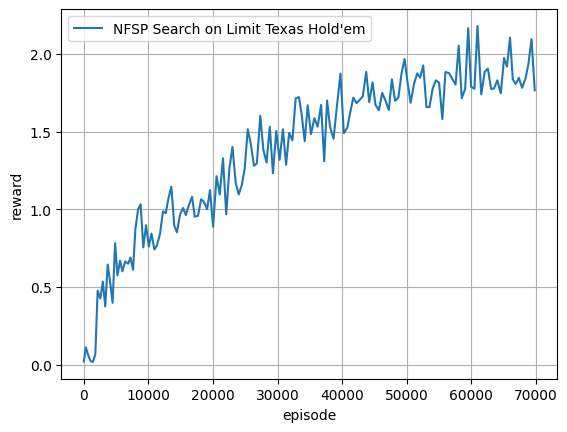

In [6]:

# Initialize the Logger and train with the best parameters found
bestNFSPagent = NFSPAgent(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    hidden_layers_sizes=best_params['hidden_layers_sizes'],
    q_mlp_layers=best_params['hidden_layers_sizes'],
    reservoir_buffer_capacity=best_params['reservoir_buffer_capacity'],
    anticipatory_param=0.1,
    batch_size=256,
    train_every=1,
    rl_learning_rate=best_params['rl_learning_rate'],
    sl_learning_rate=best_params['sl_learning_rate'],
    min_buffer_size_to_learn=1000,
    q_replay_memory_size=best_params['q_replay_memory_size'],
    q_replay_memory_init_size=1000,
    q_update_target_estimator_every=1000,
    q_discount_factor=best_params['q_discount_factor'],
    q_epsilon_start=best_params['q_epsilon_start'],
    q_epsilon_end=best_params['q_epsilon_end'],
    q_epsilon_decay_steps=10000,
    q_batch_size=256,
    q_train_every=1,
    evaluate_with='average_policy'
)

env.set_agents([bestNFSPagent, RandomAgent(num_actions=env.num_actions)])
eval_env.set_agents([bestNFSPagent, RandomAgent(num_actions=env.num_actions)])

with Logger("experiments/limit_holdem_nfsp_result/") as logger:
    for episode in range(15000):  # Increase the number of episodes
        trajectories, payoffs = env.run(is_training=True)
        trajectories = reorganize(trajectories, payoffs)

        for ts in trajectories[0]:  # Only use trajectories of the learning agent
            bestNFSPagent.feed(ts)

        if episode % 100 == 0:
            reward = tournament(eval_env, 1000)[0]
            logger.log_performance(env.timestep, reward)
            print(f'Episode {episode}, Reward: {reward}')

    csv_path, fig_path = logger.csv_path, logger.fig_path

plot_curve(csv_path, fig_path, 'NFSP Search on Limit Texas Hold\'em')

 ### 3.6.4 Conclusion
As the plot illustrates, this approach successfully identifies a parameter combination that achieves stable performance, with rewards approaching 2. Conducting a more extensive grid search with additional episodes and a larger value range could further enhance the model's performance. Given the paper's results, with an optimal setup, we would expect this agent to outperform the others.


## 3.7 Demonstration of Manual Play against Methods trained on a Random Agent <a class="anchor" id="3.7"></a>

To experience the skill level of the trained models, we played a demonstration of 5 games per agents.

In [13]:
trained_agent_list = {'Double Deep Q-Network':TwoDQNagent,
                      'Deep Fitted Q-Iteration': FittedDQagent}

for agent in trained_agent_list:
    print("Agent Name: ", agent)
    manual_play(opponent_agent = trained_agent_list[agent], num_games = 5)


Agent Name:  Double Deep Q-Network
>> Start a new game

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│9        │   │A        │
│         │   │         │
│         │   │         │
│    ♠    │   │    ♣    │
│         │   │         │
│         │   │         │
│        9│   │        A│
└─────────┘   └─────────┘
===============     Chips      ===============
Yours:   +
+++
=========== Actions You Can Choose ===========
0: call, 1: raise, 2: fold

>> You choose action (integer): 0
>> Player 0 chooses call
>> Player 1 chooses check

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐
│4        │   │J        │   │K        │
│         │   │         │   │         │
│         │   │         │   │         │
│    ♥    │   │    ♠    │   │    ♥    │
│         │   │         │   │         │
│         │   │         │   │         │
│        4│   │        J│   │        K│
└─────────┘   └──

Above is a log demonstrating manual play against the two models trained on a random agent. The best performing models, Double DQN and Deep Fitted Q-Iteration, were selected to play five games each. The agents exhibited aggressive play, rarely folding in the early stages. Both agents adopted a similar style, playing passively with calls when they had no pairs during the pre-flop, but initiating strong raises when a pair was made after the turn or river. Interestingly, both agents shifted their strategy from passive to aggressive when encountering a gutshot straight draw (one card missing from a straight). This observation highlights their strategic adaptability and their ability to identify high-potential hands.

## 4. Applying Methods to Rule-Based Agents <a class="anchor" id="chap4"></a>
In this section, we extend our investigation by training the successful reinforcement learning models identified previously against a rule-based agent, as opposed to a random agent. This approach facilitates a more rigorous evaluation of the models' performance against opponents with established strategies. By comparing the reward outcomes of these sessions with those obtained against random agents, we aim to assess the adaptability and effectiveness of the models in dynamic gameplay scenarios. This analysis offers insights into the robustness and generalization capabilities of the trained agents, highlighting their potential applicability in real-world poker environments. The RLCard library provides only a single rule-based agent for the Limit Texas Hold'em environment.

In [15]:
pre_trained_agent = models.load('limit-holdem-rule-v1').agents[0]

We now select the two best-performing agents from Section 3 (Double DQN and Deep Fitted Q-Iteration) and train them using the rule-based agent as the opponent.

## 4.1 Double-DQN-Agent vs. Rule-Based <a class="anchor" id="4.1"></a>

Episode 0

----------------------------------------
  episode      |  1
  reward       |  0.442
----------------------------------------
Episode 100

----------------------------------------
  episode      |  189
  reward       |  0.258
----------------------------------------
INFO - Step 100, rl-loss: 2.0203466415405273
INFO - Copied model parameters to target network.
INFO - Step 169, rl-loss: 3.4689834117889404Episode 200

----------------------------------------
  episode      |  395
  reward       |  0.1185
----------------------------------------
INFO - Step 260, rl-loss: 2.6188557147979736Episode 300

----------------------------------------
  episode      |  584
  reward       |  0.2095
----------------------------------------
INFO - Step 365, rl-loss: 2.885847568511963Episode 400

----------------------------------------
  episode      |  812
  reward       |  0.242
----------------------------------------
INFO - Step 451, rl-loss: 22.092973709106445Episode 500

--------------

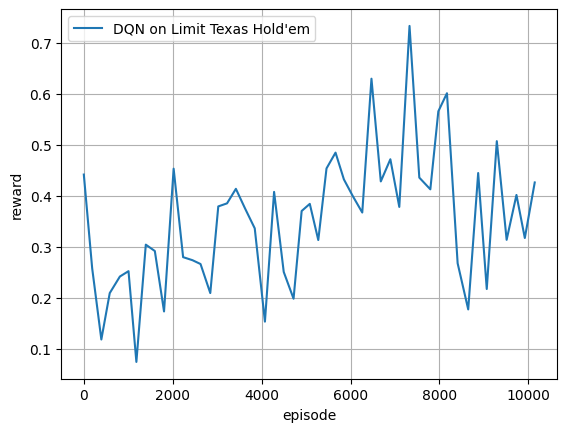

In [16]:
# Make the environment with Limit Texas Hold'em
env = rlcard.make('limit-holdem')
eval_env = rlcard.make('limit-holdem')

# Initialize a DQN agent
DQN_pretrained_agent = DQNAgent(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    mlp_layers=[64, 64],
)

# Set the agents in the environment
env.set_agents([DQN_pretrained_agent, pre_trained_agent])
eval_env.set_agents([DQN_pretrained_agent, pre_trained_agent])

# Initialize the Logger
with Logger("experiments/limit_holdem_dqn_pre_trained_result/") as logger:
    for episode in range(5000):  # Change the number of episodes based on your computational budget
        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:  # Only use trajectories of the learning agent
            DQN_pretrained_agent.feed(ts)

        # Evaluate the performance every 100 episodes
        if episode % 100 == 0:
            print(f'Episode {episode}')
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    1000  # Reduce the number for quicker evaluations
                )[0]
            )

    # Get the paths for the learning curve
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, fig_path, 'DQN on Limit Texas Hold\'em')

The application of the Double DQN algorithm to train against a rule-based agent in poker has produced contrasting reward outcomes compared to training against a randomly playing agent. Training against a random agent resulted in a rapid increase in rewards, stabilizing at a relatively high mean level. In contrast, training against a pre-trained rule-based agent led to significantly lower and more volatile reward outcomes, oscillating around a mean of 0.35BB. The Double DQN algorithm encounters greater difficulty in adapting and learning effective strategies against such opponents, leading to diminished and more erratic reward performance. This highlights the algorithm's sensitivity to opponent dynamics and underscores the need for further research and refinement to enhance its adaptability and effectiveness in competitive poker environments.

## 4.2 Deep Fitted Q-Iteration vs. Rule-Based <a class="anchor" id="4.2"></a>

Episode 0

----------------------------------------
  episode      |  1
  reward       |  0.2915
----------------------------------------
Episode 100

----------------------------------------
  episode      |  189
  reward       |  0.4435
----------------------------------------
INFO - Step 100, rl-loss: 6.8489909172058105
INFO - Copied model parameters to target network.
INFO - Step 175, rl-loss: 4.814320087432861Episode 200

----------------------------------------
  episode      |  386
  reward       |  0.367
----------------------------------------
INFO - Step 260, rl-loss: 2.382575035095215Episode 300

----------------------------------------
  episode      |  566
  reward       |  0.3495
----------------------------------------
INFO - Step 363, rl-loss: 1.780142903327942Episode 400

----------------------------------------
  episode      |  785
  reward       |  0.303
----------------------------------------
INFO - Step 456, rl-loss: 3.6857657432556152Episode 500

---------------

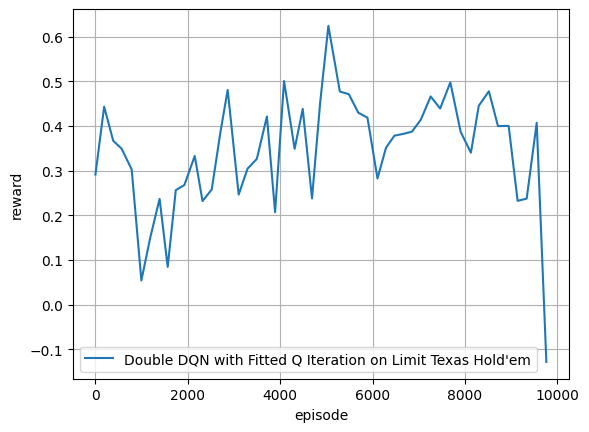

In [17]:
# Make the environment with Limit Texas Hold'em
env = rlcard.make('limit-holdem')
eval_env = rlcard.make('limit-holdem')

# Initialize the Double DQN + Fitted Q Iteration agent
DQN_fitted_pretrained_agent = DQNAgentWithFittedQ(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    mlp_layers=[64, 64],
)

# Set the agents in the environment
env.set_agents([DQN_fitted_pretrained_agent, pre_trained_agent])
eval_env.set_agents([DQN_fitted_pretrained_agent, pre_trained_agent])

# Initialize the Logger
with Logger("experiments/limit_holdem_dqn_with_fittedq_pretrained_result/") as logger:
    for episode in range(5000):  # Change the number of episodes based on your computational budget
        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:  # Only use trajectories of the learning agent
            DQN_fitted_pretrained_agent.feed(ts)

        # Evaluate the performance every 100 episodes
        if episode % 100 == 0:
            print(f'Episode {episode}')
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    1000  
                )[0]
            )

    # Get the paths for the learning curve
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, fig_path, 'Double DQN with Fitted Q Iteration on Limit Texas Hold\'em')

The application of the Deep Fitted Q-Iteration algorithm to a rule-based agent has produced reward outcomes slightly lower than those achieved with the Double DQN approach, though with less variability. The agent manages to score positive rewards almost exclusively. As discussed in Section 3, when trained against a random agent, both algorithms demonstrated increasing rewards across episodes, eventually stabilizing at a high mean reward level. However, when faced with a rule-based agent, the reward-to-episode graph for both algorithms shows oscillations around a mean of approximately 0.3BB, suggesting limited learning behavior. Nonetheless, the agents consistently achieve positive rewards even against the rule-based agent.

## 4.3 Deep Fitted Q-Iteration vs. Double Deep Q-Network  <a class="anchor" id="4.3"></a>

Episode 0

----------------------------------------
  episode      |  1
  reward       |  0.204
----------------------------------------
INFO - Step 100, rl-loss: 2.7974672317504883
INFO - Copied model parameters to target network.
INFO - Step 134, rl-loss: 2.986624240875244Episode 100

----------------------------------------
  episode      |  270
  reward       |  -0.5145
----------------------------------------
INFO - Step 286, rl-loss: 0.9160386919975281Episode 200

----------------------------------------
  episode      |  551
  reward       |  -0.574
----------------------------------------
INFO - Step 435, rl-loss: 2.998976707458496Episode 300

----------------------------------------
  episode      |  852
  reward       |  -0.791
----------------------------------------
INFO - Step 579, rl-loss: 2.757950782775879Episode 400

----------------------------------------
  episode      |  1142
  reward       |  -0.7525
----------------------------------------
INFO - Step 719, rl-loss

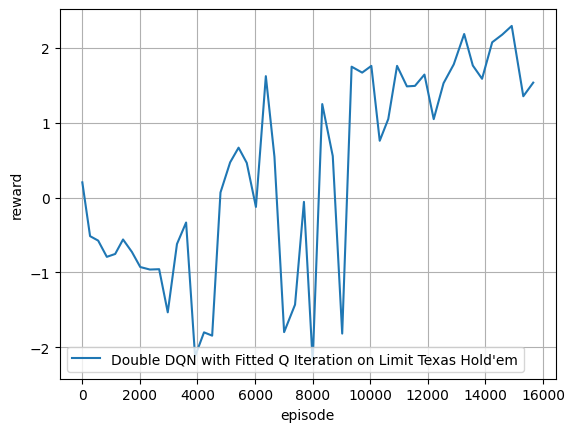

In [11]:
# Make the environment with Limit Texas Hold'em
env = rlcard.make('limit-holdem')
eval_env = rlcard.make('limit-holdem')

# Initialize the Double DQN + Fitted Q Iteration agent
DQN_FittedQ = DQNAgentWithFittedQ(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    mlp_layers=[64, 64],
)

# Initialize a DQN agent
DQN = DQNAgent(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    mlp_layers=[64, 64],
)

# Set the agents in the environment
env.set_agents([DQN_FittedQ, DQN])
eval_env.set_agents([DQN_FittedQ, DQN])

# Initialize the Logger
with Logger("experiments/limit_holdem_dqnFittedQ_vs_dqn/") as logger:
    for episode in range(5000):  # Change the number of episodes based on your computational budget
        # Generate data from the environment
        trajectories, payoffs = env.run(is_training=True)

        # Reorganize the data to be state, action, reward, next_state, done
        trajectories = reorganize(trajectories, payoffs)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:  # Only use trajectories of the learning agent
            DQN_FittedQ.feed(ts)

        # Evaluate the performance every 100 episodes
        if episode % 100 == 0:
            print(f'Episode {episode}')
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    1000  
                )[0]
            )

    # Get the paths for the learning curve
    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the learning curve
plot_curve(csv_path, fig_path, 'Double DQN with Fitted Q Iteration on Limit Texas Hold\'em')

In all previous tests, Deep Fitted Q-Iteration and Double Deep Q-Network (DQN) have performed similarly, prompting a direct comparison between the methods. The outcome is particularly interesting: While DQN initially has the upper hand, rewards then undergo a volatile period with no clear winner. Eventually, Deep Fitted Q-Iteration begins to consistently achieve high positive rewards, which continue to increase towards the final episodes. It remains to be seen whether this upward trend would persist or if the rewards might drop into the negative again with longer training. Currently, Deep Fitted Q-Iteration appears to outperform DQN, potentially due to its ensemble-based construction that combines the capabilities of both Fitted Q-Iteration and deep Q-learning, giving it an edge. Another interesting observation is that Deep Fitted Q-Iteration performs well against the sophisticated DQN agent but struggles against the rule-based agent encountered earlier. This discrepancy may be due to the rule-based agent's predictable yet strategically robust behavior, which exposes weaknesses in the adaptability and flexibility of the Fitted Q-Iteration approach. Further investigation is needed to understand and address these dynamics, which could involve refining the training procedures or enhancing the algorithm's ability to generalize across different types of opponents.

## 4.4 Demonstration of Manual Play Against Implemented Agents  <a class="anchor" id="4.3"></a>


In [18]:
trained_agent_list = {'DQN_pretrained':DQN_pretrained_agent,
                      'DQN_fitted_pretrained':DQN_fitted_pretrained_agent}

for agent in trained_agent_list:
    print("Agent Name: ", agent)
    manual_play(opponent_agent = trained_agent_list[agent], num_games = 3)

Agent Name:  DQN_pretrained
>> Start a new game
>> Player 1 chooses call

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│4        │   │Q        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♥    │
│         │   │         │
│         │   │         │
│        4│   │        Q│
└─────────┘   └─────────┘
===============     Chips      ===============
Yours:   ++
++++
=========== Actions You Can Choose ===========
0: raise, 1: fold, 2: check

>> You choose action (integer): 0
>> Player 1 chooses call
>> Player 0 chooses raise
>> Player 1 chooses raise

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│4        │   │Q        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♥    │
│         │   │         │
│         │   │         │
│        4│   │        Q│
└─────────┘   └─────────┘


The log above demonstrates manual play against the two models trained on a pre-trained agent. The agents trained with DQN exhibited more aggressive play compared to their performance against agents trained on a random agent. Both agents adopted a similar style, making strong betting moves from the pre-flop stage and only folding when necessary. This indicates that the pre-trained agent training influenced their strategic approach, leading to more assertive and calculated gameplay.

## 5. Conclusion <a class="anchor" id="cahp5"></a>

This study aimed to evaluate and compare the performance of various reinforcement learning (RL) agents in the context of Limit Texas Hold'em poker, with a particular focus on novel methods developed as part of this research. The agents tested include Counterfactual Regret Minimization (CFR), Double Q-Learning, Double Deep Q-Network (Double DQN), Deep Fitted Q-Iteration, Advantage Actor-Critic (A2C) with Fitted Q Iteration, and Neural Fictitious Self-Play (NFSP). Each agent was initially trained against a random agent and subsequently against a rule-based agent to assess its adaptability and effectiveness in different scenarios.

**Counterfactual Regret Minimization (CFR):**
Despite its theoretical effectiveness, CFR faced challenges in achieving improved rewards over successive episodes. The stagnation in rewards suggests limitations in the current implementation or parameterization of CFR, highlighting the complexity of the poker domain and the need for further refinement.

**Double Q-Learning:**
Double Q-Learning struggled with the complexities of poker, including partial observability and high variance in rewards. The algorithm encountered difficulties in accurately assessing and learning effective strategies, leading to instability and poor convergence. However, it did achieve positive rewards around 1.15, outperforming the random agent.

**Double Deep Q-Network (Double DQN):**
By leveraging neural networks, Double DQN handled complex state spaces more effectively than tabular methods. Training against a random agent resulted in a rapid increase in rewards, stabilizing at a high level. However, training against a rule-based agent led to lower and more volatile rewards, highlighting the algorithm's sensitivity to opponent dynamics. Despite these challenges, Double DQN demonstrated significant improvements over Double Q-Learning.

**Deep Fitted Q-Iteration:**
This novel method combines neural network-based function approximation with the stability of batch learning from FQI. It performed well against the random agent, reaching reward levels up to 2.50. When trained against a rule-based agent, it produced reward outcomes comparable to Double DQN, with limited learning behavior but consistent positive rewards. In a direct comparison with DQN, Deep Fitted Q-Iteration initially lags but eventually manages to outperform DQN, consistently achieving high positive rewards toward the final episodes. It is important to note however, that Deep Fitted Q-Iteration is slower than DQN and requires longer training times. This performance is likely due to its ensemble-based construction, which combines the strengths of both Fitted Q-Iteration and deep Q-learning. An interesting observation is that while Deep Fitted Q-Iteration excels against the sophisticated DQN agent, it performs poorly against the rule-based agent, possibly due to the rule-based agent's predictable yet strategically robust behavior.

**Advantage Actor-Critic (A2C) with Fitted Q Iteration:**
The A2C agent exhibited some learning behavior but performed worse than other methods such as Double DQN. The high variance in reward signals and unstable updates likely contributed to its lower performance. Despite this, the A2C agent outperformed the random agent, reaching reward levels up to 1.4.

**Neural Fictitious Self-Play (NFSP):**
Our implementation of NFSP through the RLCard API struggled to reproduce the performance reported in the literature. A grid search to find suitable parameters for our specific setting identified a combination that achieved stable performance, with rewards approaching 2. However, further extensive grid searches and additional episodes might be needed to fully realize the potential of NFSP.

### Summary and Evaluation

The study's findings indicate that while established methods like Double DQN and Deep Fitted Q-Iteration performed well, the novel methods developed, particularly Deep Fitted Q-Iteration, showed promising results. Deep Fitted Q-Iteration's ability to achieve high reward levels against random agents and maintain positive rewards against rule-based agents suggests it is a robust and effective approach for poker.

However, methods like CFR and Double Q-Learning demonstrated the challenges of applying traditional RL algorithms to the complex and dynamic environment of poker. The novel A2C with Fitted Q Iteration also highlighted the difficulties inherent in combining policy gradients with value function estimation in such settings.

Overall, this study underscores the importance of tailored RL approaches for complex strategic games like poker. The insights gained from the performance of various agents will inform future research and refinement of RL algorithms, aiming to develop more robust and proficient poker-playing agents. The promising results from novel methods like Deep Fitted Q-Iteration pave the way for further exploration and optimization in this exciting field.

## Contributions

26990: 47.5%

23685: 47.5%

Third group member: 5%
Student ID: 201919998 (we do not know their candidate number)
Unfortunately, this group member did not participate in the project after the initial meetings and has not shared any files or made any other contributions.